In [2]:
import networkx as nx
from rdkit import Chem
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mol = Chem.MolFromSmiles("C1CC2CCC3CCCC4CCC(C1)C2C34")
ssr = Chem.GetSymmSSSR(mol)

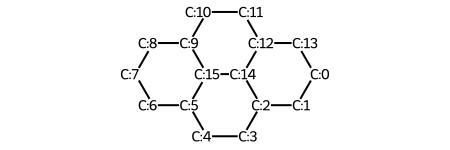

In [4]:
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
test_mol = show_atom_number(Chem.RWMol(mol), "molAtomMapNumber")
test_mol

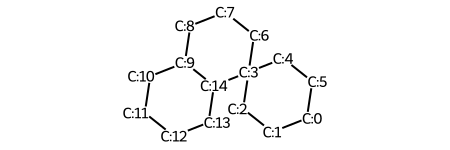

In [42]:
mol2 = Chem.MolFromSmiles("C1CCC2(CC1)CCCC1CCCCC21")
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
test_mol2 = show_atom_number(Chem.RWMol(mol2), "molAtomMapNumber")
test_mol2

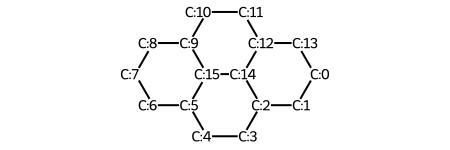

In [6]:
def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

def copy_edit_mol(mol): 

    # new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    # for atom in mol.GetAtoms():
    #     new_atom = copy_atom(atom)
    #     new_mol.AddAtom(new_atom)
    # for bond in mol.GetBonds():
    #     a1 = bond.GetBeginAtom().GetIdx()
    #     a2 = bond.GetEndAtom().GetIdx()
    #     bt = bond.GetBondType()
    #     new_mol.AddBond(a1, a2, bt)
    new_mol = Chem.RWMol(mol)

    # new_mol.AddBond(9, 5, order=Chem.BondType.UNSPECIFIED)

    # new_mol.AddBond(9, 14, order=Chem.BondType.UNSPECIFIED)

    # new_mol.AddBond(9, 12, order=Chem.BondType.UNSPECIFIED)

    # new_mol.AddBond(2, 12, order=Chem.BondType.UNSPECIFIED)

    # new_mol.AddBond(2, 15, order=Chem.BondType.UNSPECIFIED)

    # new_mol.AddBond(2, 5, order=Chem.BondType.UNSPECIFIED)

    return new_mol

copied_mol = copy_edit_mol(test_mol)
copied_mol

In [7]:
KEY = "gh"

import itertools

def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol

def get_triangulated_graph(mol):
    if mol and mol.GetNumAtoms() == 3 and mol.GetNumBonds() <= 2:
        triangulated_mol = Chem.RWMol(Chem.MolFromSmiles(''))
        for atom in mol.GetAtoms():
            new_atom = copy_atom(atom)
            triangulated_mol.AddAtom(new_atom)

        subset_possible_bonds = list(itertools.combinations(mol.GetAtoms(), 2))
        subset = [(bond[0].GetIdx(), bond[1].GetIdx()) for bond in subset_possible_bonds]

        G = nx.Graph()
        for bond in subset:
            a1, a2 = bond[0], bond[1]
            bond_obj = mol.GetBondBetweenAtoms(a1, a2)
            if bond_obj:
                triangulated_mol.AddBond(a1, a2, order=bond_obj.GetBondType())
                new_bond = triangulated_mol.GetBondBetweenAtoms(a1, a2)
                new_bond.SetBoolProp(KEY, False)
                G.add_edge(a1, a2, order=bond_obj.GetBondTypeAsDouble())
            else:
                triangulated_mol.AddBond(a1, a2, order=Chem.BondType.SINGLE)
                new_bond = triangulated_mol.GetBondBetweenAtoms(a1, a2)
                new_bond.SetBoolProp(KEY, True)
                G.add_edge(a1, a2, order=0.0)        

        return triangulated_mol.GetMol(), G
    else:
        return mol, None

def get_fragments(mol ,atoms):
    return Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)

def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol

class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):
        self.smiles = smiles
        self.mol = get_mol(self.smiles)
        self.tri_mol, self.graph = get_triangulated_graph(self.mol)

        self.clique = [x for x in clique] #copy
        self.neighbors = []
        
    def add_neighbor(self, nei_node):
        self.neighbors.append(nei_node)
    

In [8]:
cliques = [
    (9, 15, 5), (9, 15, 14), (9, 12, 14),
    (12, 14, 2), (5, 15, 14), (15, 14, 2), (15,), (8, 9, 5)
]

molTreeEdges = [
    (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7)
]

list_of_nodes = []
for clique in cliques:
    if isinstance(clique, tuple):
        c = list(clique)
        m = MolTreeNode(get_fragments(mol ,list(clique)), c)
    # else:
    #     m = MolTreeNode(c, )
    list_of_nodes.append(m)

for x,y in molTreeEdges:
    list_of_nodes[x].add_neighbor(list_of_nodes[y])
    list_of_nodes[y].add_neighbor(list_of_nodes[x])

for i,node in enumerate(list_of_nodes):
    node.nid = i + 1
    if len(node.neighbors) > 1: #Leaf node mol is not marked
        set_atommap(node.mol, node.nid)
        set_atommap(node.tri_mol, node.nid)
    node.is_leaf = (len(node.neighbors) == 1)


In [9]:
root = list_of_nodes[3]
molecule = root.tri_mol

# molecule.UpdatePropertyCache()
# for atom in molecule.GetAtoms():
#     print(atom.GetTotalNumHs())

for bond in molecule.GetBonds():
    print(bond.GetBoolProp(KEY))

False
True
False


In [10]:
def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()

def bond_prop_equal(b1, b2):
    return b1.GetBoolProp(KEY) == b2.GetBoolProp(KEY)

#Bond type not considered because all aromatic (so SINGLE matches DOUBLE)
def ring_bond_equal(b1, b2, reverse=False):
    b1 = (b1.GetBeginAtom(), b1.GetEndAtom())
    if reverse:
        b2 = (b2.GetEndAtom(), b2.GetBeginAtom())
    else:
        b2 = (b2.GetBeginAtom(), b2.GetEndAtom())
    return atom_equal(b1[0], b2[0]) and atom_equal(b1[1], b2[1]) and bond_prop_equal(b1, b2)

In [11]:
def attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap):
    prev_nids = [node.nid for node in prev_nodes]
    for nei_node in prev_nodes + neighbors:
        nei_id,nei_mol = nei_node.nid,nei_node.mol
        amap = nei_amap[nei_id]
        for atom in nei_mol.GetAtoms():
            if atom.GetIdx() not in amap:
                new_atom = copy_atom(atom)
                amap[atom.GetIdx()] = ctr_mol.AddAtom(new_atom)

        if nei_mol.GetNumBonds() == 0:
            nei_atom = nei_mol.GetAtomWithIdx(0)
            ctr_atom = ctr_mol.GetAtomWithIdx(amap[0])
            ctr_atom.SetAtomMapNum(nei_atom.GetAtomMapNum())
        else:
            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()]
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if ctr_mol.GetBondBetweenAtoms(a1, a2) is None:
                    ctr_mol.AddBond(a1, a2, bond.GetBondType())
                elif nei_id in prev_nids: #father node overrides
                    ctr_mol.RemoveBond(a1, a2)
                    ctr_mol.AddBond(a1, a2, bond.GetBondType())
    return ctr_mol

def local_attach(ctr_mol, neighbors, prev_nodes, amap_list):
    ctr_mol = copy_edit_mol(ctr_mol)
    nei_amap = {nei.nid:{} for nei in prev_nodes + neighbors}

    for nei_id,ctr_atom,nei_atom in amap_list:
        nei_amap[nei_id][nei_atom] = ctr_atom

    ctr_mol = attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap)
    return ctr_mol.GetMol()

In [12]:

# MAX_NCAND = 200

# #This version records idx mapping between ctr_mol and nei_mol
# def enum_attach(ctr_mol, nei_node, amap, singletons):
#     nei_mol,nei_idx = nei_node.mol,nei_node.nid
#     att_confs = []
#     black_list = [atom_idx for nei_id,atom_idx,_ in amap if nei_id in singletons]
#     ctr_atoms = [atom for atom in ctr_mol.GetAtoms() if atom.GetIdx() not in black_list]
#     ctr_bonds = [bond for bond in ctr_mol.GetBonds()]

#     if nei_mol.GetNumBonds() == 0: #neighbor singleton
#         nei_atom = nei_mol.GetAtomWithIdx(0)
#         used_list = [atom_idx for _,atom_idx,_ in amap]
#         for atom in ctr_atoms:
#             if atom_equal(atom, nei_atom) and atom.GetIdx() not in used_list:
#                 new_amap = amap + [(nei_idx, atom.GetIdx(), 0)]
#                 att_confs.append( new_amap )
   
#     elif nei_mol.GetNumBonds() == 1: #neighbor is a bond
#         bond = nei_mol.GetBondWithIdx(0)
#         bond_val = int(bond.GetBondTypeAsDouble())
#         b1,b2 = bond.GetBeginAtom(), bond.GetEndAtom()

#         for atom in ctr_atoms: 
#             #Optimize if atom is carbon (other atoms may change valence)
#             if atom.GetAtomicNum() == 6 and atom.GetTotalNumHs() < bond_val:
#                 continue
#             if atom_equal(atom, b1):
#                 new_amap = amap + [(nei_idx, atom.GetIdx(), b1.GetIdx())]
#                 att_confs.append( new_amap )
#             elif atom_equal(atom, b2):
#                 new_amap = amap + [(nei_idx, atom.GetIdx(), b2.GetIdx())]
#                 att_confs.append( new_amap )
#     else: 
#         #intersection is an atom
#         for a1 in ctr_atoms:
#             for a2 in nei_mol.GetAtoms():
#                 if atom_equal(a1, a2):
#                     #Optimize if atom is carbon (other atoms may change valence)
#                     if a1.GetAtomicNum() == 6 and a1.GetTotalNumHs() + a2.GetTotalNumHs() < 4:
#                         continue
#                     new_amap = amap + [(nei_idx, a1.GetIdx(), a2.GetIdx())]
#                     att_confs.append( new_amap )

#         #intersection is an bond
#         if ctr_mol.GetNumBonds() > 1:
#             for b1 in ctr_bonds:
#                 for b2 in nei_mol.GetBonds():
#                     if ring_bond_equal(b1, b2):
#                         new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetBeginAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetEndAtom().GetIdx())]
#                         att_confs.append( new_amap )

#                     if ring_bond_equal(b1, b2, reverse=True):
#                         new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetEndAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetBeginAtom().GetIdx())]
#                         att_confs.append( new_amap )
#     return att_confs


# def enum_assemble(node, neighbors, prev_nodes=[], prev_amap=[]):
#     all_attach_confs = []
#     singletons = [nei_node.nid for nei_node in neighbors + prev_nodes if nei_node.mol.GetNumAtoms() == 1]

#     def search(cur_amap, depth):
#         if len(all_attach_confs) > MAX_NCAND:
#             return
#         if depth == len(neighbors):
#             all_attach_confs.append(cur_amap)
#             return

#         nei_node = neighbors[depth]
#         cand_amap = enum_attach(node.mol, nei_node, cur_amap, singletons)
#         print('cand_amap', cand_amap)
#         cand_smiles = set()
#         candidates = []
#         for amap in cand_amap:
#             cand_mol = local_attach(node.mol, neighbors[:depth+1], prev_nodes, amap)
#             print(Chem.MolToSmiles(cand_mol))
#             # cand_mol = sanitize(cand_mol)
#             # if cand_mol is None:
#             #     continue
#             # smiles = get_smiles(cand_mol)
#             # if smiles in cand_smiles:
#             #     continue
#             # cand_smiles.add(smiles)
#             # candidates.append(amap)
#         raise

#         # if len(candidates) == 0:
#         #     return

#         # for new_amap in candidates:
#         #     search(new_amap, depth + 1)

#     search(prev_amap, 0)
#     # cand_smiles = set()
#     # candidates = []
#     # for amap in all_attach_confs:
#     #     cand_mol = local_attach(node.mol, neighbors, prev_nodes, amap)
#     #     cand_mol = Chem.MolFromSmiles(Chem.MolToSmiles(cand_mol))
#     #     smiles = Chem.MolToSmiles(cand_mol)
#     #     if smiles in cand_smiles:
#     #         continue
#     #     cand_smiles.add(smiles)
#     #     Chem.Kekulize(cand_mol)
#     #     candidates.append( (smiles,cand_mol,amap) )

#     # return candidates

# #Only used for debugging purpose
# def dfs_assemble(cur_mol, global_amap, fa_amap, cur_node, fa_node):
#     fa_nid = fa_node.nid if fa_node is not None else -1
#     prev_nodes = [fa_node] if fa_node is not None else []

#     children = [nei for nei in cur_node.neighbors if nei.nid != fa_nid]
#     neighbors = [nei for nei in children if nei.mol.GetNumAtoms() > 1]
#     neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
#     singletons = [nei for nei in children if nei.mol.GetNumAtoms() == 1]
#     neighbors = singletons + neighbors

#     cur_amap = [(fa_nid,a2,a1) for nid,a1,a2 in fa_amap if nid == cur_node.nid] # check if there is any atommap has been occupied previously when attaching with parent
#     cands = enum_assemble(cur_node, neighbors, prev_nodes, cur_amap)

#     # if not cands: return

#     # cand_smiles,cand_amap = zip(*cands)
#     # label_idx = cand_smiles.index(cur_node.label)
#     # label_amap = cand_amap[label_idx]

#     # for nei_id,ctr_atom,nei_atom in label_amap:
#     #     if nei_id == fa_nid:
#     #         continue
#     #     global_amap[nei_id][nei_atom] = global_amap[cur_node.nid][ctr_atom]
    
#     # cur_mol = attach_mols(cur_mol, children, [], global_amap) #father is already attached
#     # for nei_node in children:
#     #     if not nei_node.is_leaf:
#     #         dfs_assemble(cur_mol, global_amap, label_amap, nei_node, cur_node)

# root = list_of_nodes[-1]
# cur_mol = copy_edit_mol(root.tri_mol)
# global_amap = [{}] + [{} for node in list_of_nodes]
# global_amap[1] = {atom.GetIdx():atom.GetIdx() for atom in cur_mol.GetAtoms()}

# global_amap
# dfs_assemble(cur_mol, global_amap, [], root, None)

In [13]:
# ON MOL

def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

def atom_equal(a1, a2):
    return a1.GetSymbol() == a2.GetSymbol() and a1.GetFormalCharge() == a2.GetFormalCharge()


#Bond type not considered because all aromatic (so SINGLE matches DOUBLE)
def ring_bond_equal(b1, b2, reverse=False):
    b1 = (b1.GetBeginAtom(), b1.GetEndAtom())
    if reverse:
        b2 = (b2.GetEndAtom(), b2.GetBeginAtom())
    else:
        b2 = (b2.GetBeginAtom(), b2.GetEndAtom())
    return atom_equal(b1[0], b2[0]) and atom_equal(b1[1], b2[1])

def copy_edit_mol(mol):
    new_mol = Chem.RWMol(Chem.MolFromSmiles(''))
    for atom in mol.GetAtoms():
        new_atom = copy_atom(atom)
        new_mol.AddAtom(new_atom)
    for bond in mol.GetBonds():
        a1 = bond.GetBeginAtom().GetIdx()
        a2 = bond.GetEndAtom().GetIdx()
        bt = bond.GetBondType()
        new_mol.AddBond(a1, a2, bt)
    return new_mol


ctr_mol = Chem.MolFromSmiles("C1C=C1")
nei_mol = Chem.MolFromSmiles("C1C=C1")

ctr_mol = copy_edit_mol(ctr_mol)

cands = []
for b1 in ctr_mol.GetBonds():
    b1_st, b1_ed = b1.GetBeginAtom().GetIdx(), b1.GetEndAtom().GetIdx()

    for b2 in nei_mol.GetBonds():
        b2_st, b2_ed = b2.GetBeginAtom().GetIdx(), b2.GetEndAtom().GetIdx()
        if ring_bond_equal(b1, b2):
            cand = copy_edit_mol(ctr_mol.GetMol())

            amap = {b2_st : b1_st, b2_ed: b1_ed}

            for atom in nei_mol.GetAtoms():
                if atom.GetIdx() not in amap: # get all atoms into amap
                    new_atom = copy_atom(atom)
                    amap[atom.GetIdx()] = cand.AddAtom(new_atom)

            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()] # notice amap keys is nei_atom idx, thus retrieving ctr atom index
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if cand.GetBondBetweenAtoms(a1, a2) is None:
                    cand.AddBond(a1, a2, bond.GetBondType())

            cands.append(cand)

        elif ring_bond_equal(b1, b2, reverse=True):
            cand = copy_edit_mol(ctr_mol.GetMol())

            amap = {b2_st : b1_ed, b2_ed: b1_st}

            for atom in nei_mol.GetAtoms():
                if atom.GetIdx() not in amap: # get all atoms into amap
                    new_atom = copy_atom(atom)
                    amap[atom.GetIdx()] = cand.AddAtom(new_atom)

            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()] # notice amap keys is nei_atom idx, thus retrieving ctr atom index
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if cand.GetBondBetweenAtoms(a1, a2) is None:
                    cand.AddBond(a1, a2, bond.GetBondType())

            cands.append(cand)

for cand in cands:
    print(Chem.MolToSmiles(cand))



        

C1=C2=CC12
C1=C2CC12
C1=C2C=C12
C1=C2=C1C2
C1C2=C1C2
C1=C2=C1C2
C1=C2C=C12
C1=C2CC12
C1=C2=CC12


In [14]:
def mol_to_nx(mol):
    G = nx.Graph()

    for atom in mol.GetAtoms():
        G.add_node(atom.GetIdx(),
                   symbol=atom.GetSymbol(),
                   formal_charge=atom.GetFormalCharge(),
                   chiral_tag=atom.GetChiralTag(),
                   hybridization=atom.GetHybridization(),
                   num_explicit_hs=atom.GetNumExplicitHs(),
                   is_aromatic=atom.GetIsAromatic())
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(),
                   bond.GetEndAtomIdx(),
                   bond_type=bond.GetBondType(),
                   ghost=bond.GetBoolProp(KEY),
                   color='r' if bond.GetBoolProp(KEY) else 'b',
                   )
    return G

def nx_to_mol(G):
    mol = Chem.RWMol()
    atomic_nums = nx.get_node_attributes(G, 'symbol')
    chiral_tags = nx.get_node_attributes(G, 'chiral_tag')
    formal_charges = nx.get_node_attributes(G, 'formal_charge')
    node_is_aromatics = nx.get_node_attributes(G, 'is_aromatic')
    node_hybridizations = nx.get_node_attributes(G, 'hybridization')
    num_explicit_hss = nx.get_node_attributes(G, 'num_explicit_hs')
    node_to_idx = {}
    for node in G.nodes():
        a=Chem.Atom(atomic_nums[node])
        a.SetChiralTag(chiral_tags[node])
        a.SetFormalCharge(formal_charges[node])
        a.SetIsAromatic(node_is_aromatics[node])
        a.SetHybridization(node_hybridizations[node])
        a.SetNumExplicitHs(num_explicit_hss[node])
        idx = mol.AddAtom(a)
        node_to_idx[node] = idx

    bond_types = nx.get_edge_attributes(G, 'bond_type')
    ghost = nx.get_edge_attributes(G, 'ghost')
    for edge in G.edges():
        first, second = edge
        ifirst = node_to_idx[first]
        isecond = node_to_idx[second]
        bond_type = bond_types[first, second]
        mol.AddBond(ifirst, isecond, bond_type)
        new_bond = mol.GetBondBetweenAtoms(ifirst, isecond)
        new_bond.SetBoolProp(KEY, ghost[first, second])
        
    try: Chem.SanitizeMol(mol)
    except: pass
    return mol

In [15]:

# def atom_equal(node1, node2):
#     return node1["symbol"] == node2["symbol"] and node1["formal_charge"] == node2["formal_charge"]

# def ring_edge_equal(edge1, edge2):
#     return edge1["bond_type"] == edge2["bond_type"] and \
#         edge1["ghost"] == edge2["ghost"]


# ctr_mol = Chem.MolFromSmiles("C1C=C1")
# nei_mol = Chem.MolFromSmiles("C1C=C1")
# for bond in ctr_mol.GetBonds():
#     if bond.GetBondTypeAsDouble() == 2.0:
#         bond.SetBoolProp(KEY, True)
#     else:
#         bond.SetBoolProp(KEY, False)
# for bond in nei_mol.GetBonds():
#     if bond.GetBondTypeAsDouble() == 2.0:
#         bond.SetBoolProp(KEY, True)
#     else:
#         bond.SetBoolProp(KEY, False)

# ctr_G = mol_to_nx(ctr_mol)
# nei_G = mol_to_nx(nei_mol)

# # colors_ctr_G = nx.get_edge_attributes(ctr_G,'color').values()
# # colors_nei_G = nx.get_edge_attributes(nei_G,'color').values()
# # nx.draw(ctr_G, node_color="yellow", with_labels=True, edge_color=colors_ctr_G)
# # plt.show()
# # nx.draw(nei_G, node_color="yellow", with_labels=True, edge_color=colors_nei_G)
# # plt.show()

# nx.is_isomorphic(ctr_G, nei_G, node_match=atom_equal, edge_match=ring_edge_equal)



[23:15:39] Explicit valence for atom # 1 C, 7, is greater than permitted


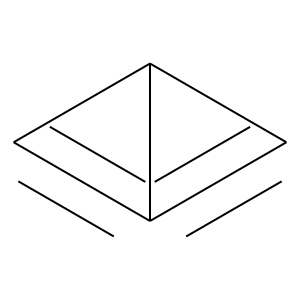

C1#C2#CC12


[23:15:39] Explicit valence for atom # 1 C, 7, is greater than permitted
[23:15:39] Explicit valence for atom # 1 C, 5, is greater than permitted


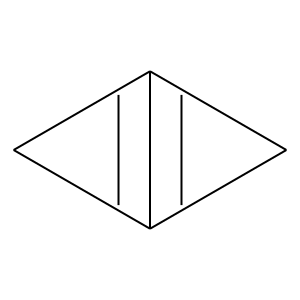

C1C2#C1C2


[23:15:39] Explicit valence for atom # 1 C, 5, is greater than permitted


In [38]:
# ON NETWORKX GRAPH

def node_equal_iso(node1, node2):
    return node1["symbol"] == node2["symbol"] and node1["formal_charge"] == node2["formal_charge"]

def ring_edge_equal_iso(edge1, edge2):
    return edge1["bond_type"] == edge2["bond_type"] and \
        edge1["ghost"] == edge2["ghost"]


def copy_node_attr(G, idx):
    val = {
        "symbol": G.nodes[idx]["symbol"],
        "chiral_tag": G.nodes[idx]["chiral_tag"],
        "formal_charge": G.nodes[idx]["formal_charge"],
        "is_aromatic": G.nodes[idx]["is_aromatic"],
        "hybridization": G.nodes[idx]["hybridization"],
        "num_explicit_hs": G.nodes[idx]["num_explicit_hs"],
    }

    return val

def node_equal(a1, a2):
    return a1["symbol"] == a2["symbol"] and a1["formal_charge"] == a2["formal_charge"]


#Bond type not considered because all aromatic (so SINGLE matches DOUBLE)
def ring_edge_equal(G1, G2, b1, b2, reverse=False):
    bond_prop = G1.get_edge_data(*b1) == G2.get_edge_data(*b2)
    if reverse: b2 = b2[::-1]
    return node_equal(G1.nodes[b1[0]], G2.nodes[b2[0]]) and node_equal(G1.nodes[b1[1]], G2.nodes[b2[1]]) and bond_prop

def draw_mol(cand_G, numb=0, attr=['symbol', 'bond_type', 'color']):
    plt.clf()
    symbol, bond_type, color = attr

    pos = nx.spring_layout(cand_G)
    nx.draw(cand_G, pos)
    node_labels = nx.get_node_attributes(cand_G, symbol)
    node_labels = {k : "     {}".format(v) for k, v in node_labels.items()}
    nx.draw_networkx_labels(cand_G, pos, node_labels)
    edge_labels = nx.get_edge_attributes(cand_G, bond_type)
    nx.draw_networkx_edge_labels(cand_G, pos, edge_labels)
    colors_cand_G = nx.get_edge_attributes(cand_G, color).values()
    nx.draw(cand_G, pos, node_color="yellow", with_labels=True, edge_color=colors_cand_G)
    plt.show()
    plt.clf()

    return
    

ctr_mol = Chem.MolFromSmiles("C1C#C1")
nei_mol = Chem.MolFromSmiles("C1C#C1")

for bond in ctr_mol.GetBonds():
    if bond.GetBondTypeAsDouble() == 2.0:
        bond.SetBoolProp(KEY, True)
    else:
        bond.SetBoolProp(KEY, False)
for bond in nei_mol.GetBonds():
    if bond.GetBondTypeAsDouble() == 2.0:
        bond.SetBoolProp(KEY, True)
    else:
        bond.SetBoolProp(KEY, False)

ctr_G = mol_to_nx(ctr_mol)
nei_G = mol_to_nx(nei_mol)


def local_attach_graph(cand_G, nei_G, amap):
    for node in nei_G.nodes():
        if node not in amap:
            node_attr = copy_node_attr(nei_G, node)
            amap[node] = len(cand_G.nodes)
            cand_G.add_node(len(cand_G.nodes), **node_attr)
    
    for node1, node2, data in nei_G.edges(data=True):
        a1 = amap[node1]
        a2 = amap[node2]
        if not cand_G.has_edge(a1, a2):
            cand_G.add_edge(a1, a2, **data)

cands_G = []
for b1 in ctr_G.edges():
    b1_st, b1_ed = b1[0], b1[1]

    for b2 in nei_G.edges():
        b2_st, b2_ed = b2[0], b2[1]

        if ring_edge_equal(ctr_G, nei_G, b1, b2):
            cand_G = ctr_G.copy()
            amap = {b2_st : b1_st, b2_ed: b1_ed}
            local_attach_graph(cand_G, nei_G, amap)


        elif ring_edge_equal(ctr_G, nei_G, b1, b2, reverse=True):
            cand_G = ctr_G.copy()
            amap = {b2_st : b1_ed, b2_ed: b1_st}
            local_attach_graph(cand_G, nei_G, amap)
            
        # draw_mol(cand_G, *['symbol', 'bond_type', 'color'])

        duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
        if not duplicate: cands_G.append(cand_G)

            

for G in cands_G:
    cand = nx_to_mol(G)
    Chem.Kekulize(cand)
    img = Chem.Draw.MolToImage(cand)
    display(img)
    print(Chem.MolToSmiles(cand))

In [17]:
# ON MOL 

ctr_mol = Chem.MolFromSmiles("C1C2C3C4C3C124")

nei_mol = Chem.MolFromSmiles("C1C=C1")
# nei_mol = Chem.MolFromSmiles("C1CCCCC1")

# ctr_mol = Chem.MolFromSmiles("C1CC2CCCC3CCCC(C1)C23")
# nei_mol = Chem.MolFromSmiles("C1CCCCC1")

ctr_pair_bonds = []
for atom in ctr_mol.GetAtoms():
    nei_n_ctr = [(atom.GetIdx(), nei.GetIdx()) for nei in atom.GetNeighbors()]
    subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
    ctr_pair_bonds.extend(subset_possible_bonds)

nei_pair_bonds = []
for atom in nei_mol.GetAtoms():
    nei_n_ctr = [(atom.GetIdx(), nei.GetIdx()) for nei in atom.GetNeighbors()]
    subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
    nei_pair_bonds.extend(subset_possible_bonds)

cands = []
for b1, b2 in ctr_pair_bonds:
    bond1 = ctr_mol.GetBondBetweenAtoms(b1[0], b1[1])
    bond2 = ctr_mol.GetBondBetweenAtoms(b2[0], b2[1])
    ctr_ctr_node = list(set(b1).intersection(set(b2)))[0]
    ctr_left_node = list(set(b1) - set(b1).intersection(set(b2)))[0]
    ctr_right_node = list(set(b2) - set(b1).intersection(set(b2)))[0]
    

    for b3, b4 in nei_pair_bonds:
        bond3 = nei_mol.GetBondBetweenAtoms(b3[0], b3[1])
        bond4 = nei_mol.GetBondBetweenAtoms(b4[0], b4[1])
        nei_ctr_node = list(set(b3).intersection(set(b4)))[0]
        nei_left_node = list(set(b3) - set(b3).intersection(set(b4)))[0]
        nei_right_node = list(set(b4) - set(b3).intersection(set(b4)))[0]
 
        if ring_bond_equal(bond1, bond3) and ring_bond_equal(bond2, bond4):
            cand = copy_edit_mol(ctr_mol)

            amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_left_node, nei_right_node: ctr_right_node}

            for atom in nei_mol.GetAtoms():
                if atom.GetIdx() not in amap: # get all atoms into amap
                    new_atom = copy_atom(atom)
                    amap[atom.GetIdx()] = cand.AddAtom(new_atom)

            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()] # notice amap keys is nei_atom idx, thus retrieving ctr atom index
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if cand.GetBondBetweenAtoms(a1, a2) is None:
                    cand.AddBond(a1, a2, bond.GetBondType())

            cands.append(cand)

        elif ring_bond_equal(bond1, bond3, reverse=True) and ring_bond_equal(bond2, bond4, reverse=True):
            cand = copy_edit_mol(ctr_mol)

            amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_right_node, nei_right_node: ctr_left_node}

            for atom in nei_mol.GetAtoms():
                if atom.GetIdx() not in amap: # get all atoms into amap
                    new_atom = copy_atom(atom)
                    amap[atom.GetIdx()] = cand.AddAtom(new_atom)

            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()] # notice amap keys is nei_atom idx, thus retrieving ctr atom index
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if cand.GetBondBetweenAtoms(a1, a2) is None:
                    cand.AddBond(a1, a2, bond.GetBondType())

            cands.append(cand)

displayed = []
for cand in cands:
    smiles = Chem.MolToSmiles(cand)
    if smiles not in displayed:
        displayed.append(smiles)
        print(smiles)

C1C2C3C4C3C124
C12=C34C1C21C3C14
C12C3C14C1C4C231
C1C2C34=C125C3C45
C1C2C34C5C3C1254
C1C23C4C5C12=C453
C1C23C4C5C12C453
C12=C34C5C1C23C54
C12C3C4C15C2C345


In [18]:
# ON NETWORKX GRAPH

ctr_mol = Chem.MolFromSmiles("C1C23C4C5C12C345")
nei_mol = Chem.MolFromSmiles("C1CC1")
# nei_mol = Chem.MolFromSmiles("C1C=C1")

# ctr_mol = Chem.MolFromSmiles("C1CC2CCCC3CCCC(C1)C23")
# nei_mol = Chem.MolFromSmiles("C1CCCCC1")
# nei_mol = Chem.MolFromSmiles("C1CCCCC1")

for bond in ctr_mol.GetBonds():
    if bond.GetBondTypeAsDouble() == 2.0:
        bond.SetBoolProp(KEY, True)
    else:
        bond.SetBoolProp(KEY, False)
# for bond in nei_mol.GetBonds():
#     if bond.GetBondTypeAsDouble() == 2.0:
#         bond.SetBoolProp(KEY, True)
#     else:
#         bond.SetBoolProp(KEY, False)

for bond in nei_mol.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()

    if (a1 == 0 and a2 == 1) or (a1 == 1 and a2 == 0):
        bond.SetBoolProp(KEY, True)
    else:
        bond.SetBoolProp(KEY, False)

ctr_G = mol_to_nx(ctr_mol)
nei_G = mol_to_nx(nei_mol)


ctr_pair_bonds = []
for node in ctr_G.nodes():
    nei_n_ctr = [(nei, node) for nei in ctr_G.neighbors(node)]
    subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
    ctr_pair_bonds.extend(subset_possible_bonds)

nei_pair_bonds = []
for node in nei_G.nodes():
    nei_n_ctr = [(nei, node) for nei in nei_G.neighbors(node)]
    subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
    nei_pair_bonds.extend(subset_possible_bonds)


cands_G = []
for b1, b2 in ctr_pair_bonds:
    ctr_ctr_node = list(set(b1).intersection(set(b2)))[0]
    ctr_left_node = list(set(b1) - set(b1).intersection(set(b2)))[0]
    ctr_right_node = list(set(b2) - set(b1).intersection(set(b2)))[0]
    
    for b3, b4 in nei_pair_bonds:
        nei_ctr_node = list(set(b3).intersection(set(b4)))[0]
        nei_left_node = list(set(b3) - set(b3).intersection(set(b4)))[0]
        nei_right_node = list(set(b4) - set(b3).intersection(set(b4)))[0]
 
        if ring_edge_equal(ctr_G, nei_G, b1, b3) and ring_edge_equal(ctr_G, nei_G, b2, b4):
            cand_G = ctr_G.copy()
            amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_left_node, nei_right_node: ctr_right_node}

            for node in nei_G.nodes():
                if node not in amap:
                    node_attr = copy_node_attr(nei_G, node)
                    amap[node] = len(cand_G.nodes)
                    cand_G.add_node(len(cand_G.nodes), **node_attr)
            
            for node1, node2, data in nei_G.edges(data=True):
                a1 = amap[node1]
                a2 = amap[node2]
                if not cand_G.has_edge(a1, a2):
                    cand_G.add_edge(a1, a2, **data)

        elif ring_edge_equal(ctr_G, nei_G, b1, b3, reverse=True) and ring_edge_equal(ctr_G, nei_G, b2, b4, reverse=True):
            cand_G = ctr_G.copy()
            amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_right_node, nei_right_node: ctr_left_node}

            for node in nei_G.nodes():
                if node not in amap:
                    node_attr = copy_node_attr(nei_G, node)
                    amap[node] = len(cand_G.nodes)
                    cand_G.add_node(len(cand_G.nodes), **node_attr)
            
            for node1, node2, data in nei_G.edges(data=True):
                a1 = amap[node1]
                a2 = amap[node2]
                if not cand_G.has_edge(a1, a2):
                    cand_G.add_edge(a1, a2, **data)

        duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
        if not duplicate: cands_G.append(cand_G)
            # draw_mol(cand_G, *['symbol', 'bond_type', 'color'])

cand_label = Chem.MolFromSmiles("C12C34C5C11C23C451")
for bond in cand_label.GetBonds():
    a1 = bond.GetBeginAtom().GetIdx()
    a2 = bond.GetEndAtom().GetIdx()

    if (a1 == 0 and a2 == 1) or (a1 == 1 and a2 == 0):
        bond.SetBoolProp(KEY, True)
    else:
        bond.SetBoolProp(KEY, False)
cand_G_label = mol_to_nx(cand_label)

# for G in cands_G:
#     draw_mol(G, *['symbol', 'bond_type', 'color'])
#     match = nx.is_isomorphic(G, cand_G_label, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)
#     print(match)

#     cand = nx_to_mol(G)
#     img = Chem.Draw.MolToImage(cand)
#     display(img)
#     print(Chem.MolToSmiles(cand))
#     print("\n\n")


# cand_label = Chem.MolFromSmiles("C12C34C5C11C23C451")
# def show_atom_number(mol, label):
#     for atom in mol.GetAtoms():
#         atom.SetProp(label, str(atom.GetIdx()))
#     return mol
# cand_label = show_atom_number(Chem.RWMol(cand_label), "molAtomMapNumber")

# a1_count = 0
# a2_count = 0
# for bond in cand_label.GetBonds():
#     a1 = bond.GetBeginAtom()
#     a2 = bond.GetEndAtom()

#     if len(a1.GetNeighbors()) == 3 and a1_count < 2:
#         bond.SetBoolProp(KEY, True)
#         a1_count += 1
#     elif len(a2.GetNeighbors()) == 3 and a2_count < 2:
#         bond.SetBoolProp(KEY, True)
#         a2_count += 1
#     else:
#         bond.SetBoolProp(KEY, False)

# cand_G_label = mol_to_nx(cand_label)

# for cand_G in cands_G:


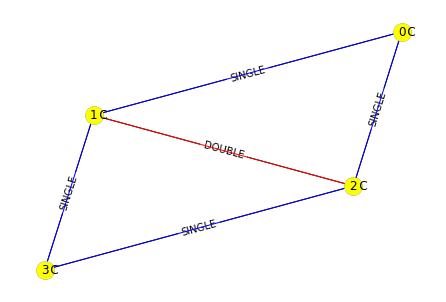

cand_label_match:  False
subgraph_match:  False




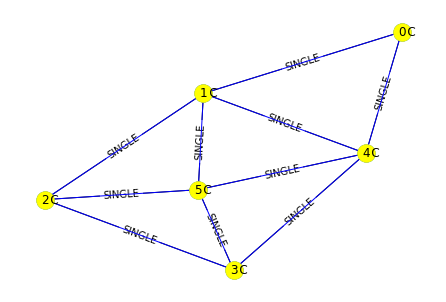

cand_label_match:  False
subgraph_match:  True




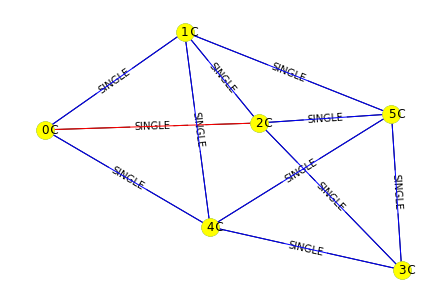

cand_label_match:  True
subgraph_match:  True




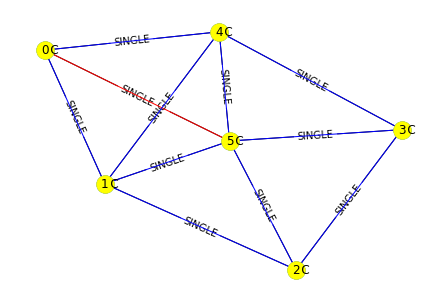

cand_label_match:  False
subgraph_match:  True




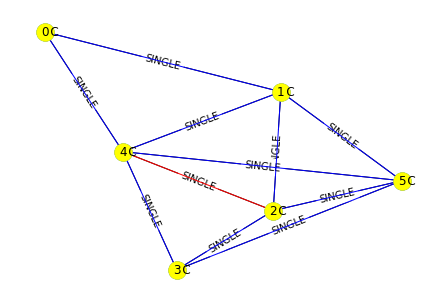

cand_label_match:  False
subgraph_match:  True




<Figure size 432x288 with 0 Axes>

In [19]:
# subgraph matching
import networkx.algorithms.isomorphism as iso

nei_mol = Chem.MolFromSmiles("C1CC1")
for bond in nei_mol.GetBonds():
    # a1 = bond.GetBeginAtom().GetIdx()
    # a2 = bond.GetEndAtom().GetIdx()

    # if (a1 == 0 and a2 == 1) or (a1 == 1 and a2 == 0):
    #     bond.SetBoolProp(KEY, True)
    # else:
    #     bond.SetBoolProp(KEY, False)
    bond.SetBoolProp(KEY, False)
nei_G = mol_to_nx(nei_mol)

for cand_G in cands_G:
    match = nx.is_isomorphic(cand_G, cand_G_label, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)

    G1 = nei_G
    G2 = cand_G
    draw_mol(cand_G, 0, ['symbol', 'bond_type', 'color'])
    GM = iso.GraphMatcher(G2,G1, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)

    print('cand_label_match: ', match)
    print('subgraph_match: ', GM.subgraph_is_isomorphic())
    print("\n")

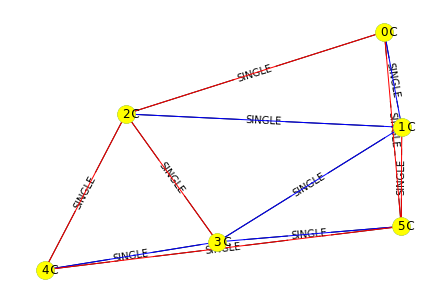

'C12C34C5C16C23C546'

<Figure size 432x288 with 0 Axes>

In [20]:
# cand_label = Chem.MolFromSmiles("C12C34C5C11C23C451")
cand_label = Chem.MolFromSmiles("CC(C)C(C)C")
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
cand_label = show_atom_number(Chem.RWMol(cand_label), "molAtomMapNumber")

cand_label = copy_edit_mol(cand_label)
ghost_edges = [(1, 5), (0, 5), (4, 5), (2, 3), (2, 4), (0, 2)]

for edge in ghost_edges:
    a1, a2 = edge
    cand_label.AddBond(a1, a2, order=Chem.BondType.SINGLE)
    new_bond = cand_label.GetBondBetweenAtoms(a1, a2)
    new_bond.SetBoolProp(KEY, True)

for bond in cand_label.GetBonds():
    try: bond.GetBoolProp(KEY)
    except: bond.SetBoolProp(KEY, False)

cand_G_label = mol_to_nx(cand_label)
draw_mol(cand_G_label, 0, ['symbol', 'bond_type', 'color'])
cand_label = nx_to_mol(cand_G_label)
Chem.MolToSmiles(cand_label)

In [81]:
# list(cand_G_label.edges.data())
# dir(list(cand_G_label.nodes.data())[0][1]["chiral_tag"])
list(cand_G_label.nodes.data())[0][1]["chiral_tag"].names

{'CHI_UNSPECIFIED': rdkit.Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
 'CHI_TETRAHEDRAL_CW': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
 'CHI_TETRAHEDRAL_CCW': rdkit.Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
 'CHI_OTHER': rdkit.Chem.rdchem.ChiralType.CHI_OTHER}

In [100]:
import json
edges_data = []
for n1, n2, data in cand_G_label.edges.data():
    data = json.dumps(data)
    edges_data.append((n1, n2, data))

nodes_data = []
for n, data in cand_G_label.nodes.data():
    data = json.dumps(data)
    nodes_data.append((n, data))

In [21]:
[node for node in cand_G.nodes() if len(list(cand_G_label.neighbors(node))) > 3]

[1, 2, 3, 5]

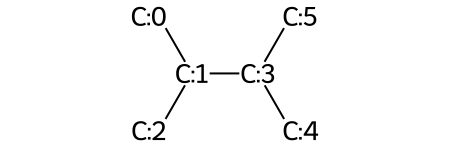

In [22]:
cand_label2 = Chem.MolFromSmiles("CC(C)C(C)C")
def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
show_atom_number(Chem.RWMol(cand_label2), "molAtomMapNumber")

In [23]:
def copy_atom(atom):
    new_atom = Chem.Atom(atom.GetSymbol())
    new_atom.SetFormalCharge(atom.GetFormalCharge())
    new_atom.SetAtomMapNum(atom.GetAtomMapNum())
    return new_atom

def set_atommap(mol, num=0):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(num)

def get_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    Chem.Kekulize(mol)
    return mol

def get_triangulated_graph(mol):
    if mol and mol.GetNumAtoms() == 3 and mol.GetNumBonds() <= 2:
        triangulated_mol = Chem.RWMol(Chem.MolFromSmiles(''))
        for atom in mol.GetAtoms():
            new_atom = copy_atom(atom)
            triangulated_mol.AddAtom(new_atom)

        subset_possible_bonds = list(itertools.combinations(mol.GetAtoms(), 2))
        subset = [(bond[0].GetIdx(), bond[1].GetIdx()) for bond in subset_possible_bonds]

        # G = nx.Graph()
        for bond in subset:
            a1, a2 = bond[0], bond[1]
            bond_obj = mol.GetBondBetweenAtoms(a1, a2)
            if bond_obj:
                triangulated_mol.AddBond(a1, a2, order=bond_obj.GetBondType())
                new_bond = triangulated_mol.GetBondBetweenAtoms(a1, a2)
                new_bond.SetBoolProp(KEY, False)
                # G.add_edge(a1, a2, order=bond_obj.GetBondTypeAsDouble())
            else:
                triangulated_mol.AddBond(a1, a2, order=Chem.BondType.SINGLE)
                new_bond = triangulated_mol.GetBondBetweenAtoms(a1, a2)
                new_bond.SetBoolProp(KEY, True)
                # G.add_edge(a1, a2, order=0.0)        

        mol = triangulated_mol.GetMol()
        mol.UpdatePropertyCache() # getNumImplicitHs() called without preceding call to calcImplicitValence()
        G = mol_to_nx(mol)

        return mol, G
    else:
        return mol, None

def get_fragments(mol, atoms):
    return Chem.MolFragmentToSmiles(mol, atoms, kekuleSmiles=True)



class MolTreeNode(object):

    def __init__(self, smiles, clique=[]):
        self.smiles = smiles
        self.mol = get_mol(self.smiles)
        self.tri_mol, self.graph = get_triangulated_graph(self.mol)

        self.clique = [x for x in clique] #copy
        self.neighbors = []
        
    def add_neighbor(self, nei_node):
        self.neighbors.append(nei_node)

current depth 1
current depth 2
current depth 3
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 3
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 3
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 3
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4
current depth 4


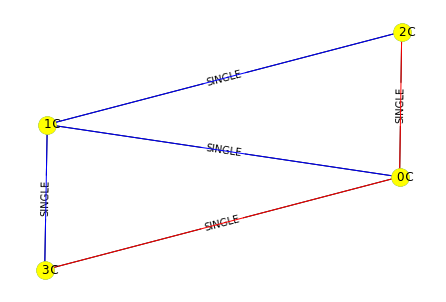

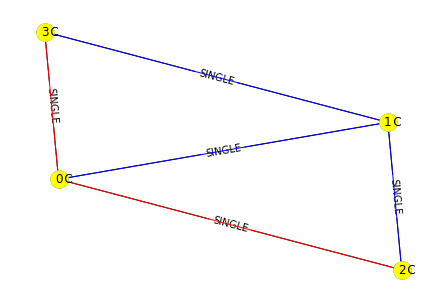

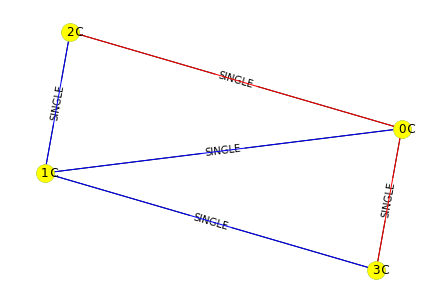

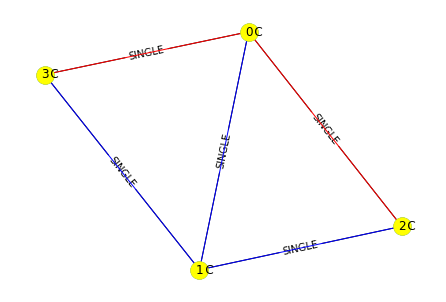

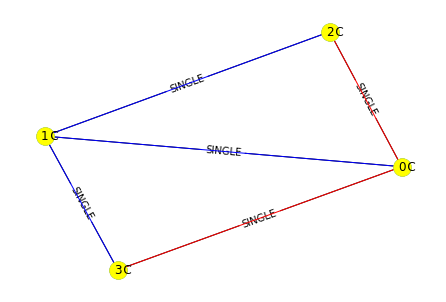

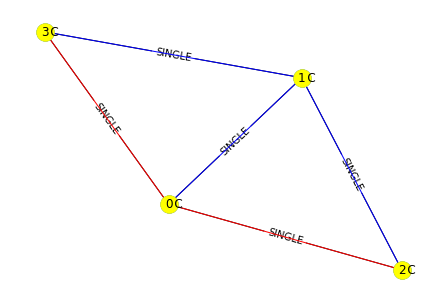

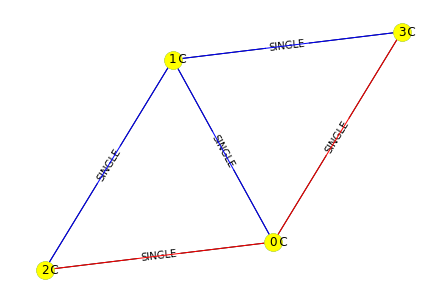

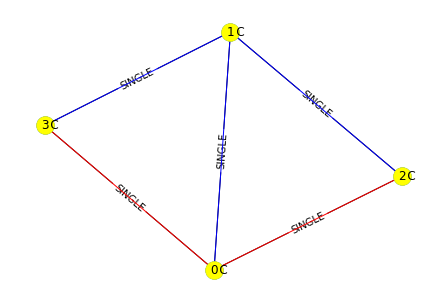

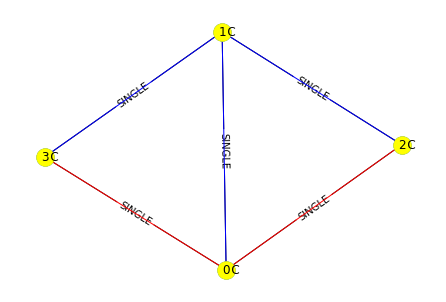

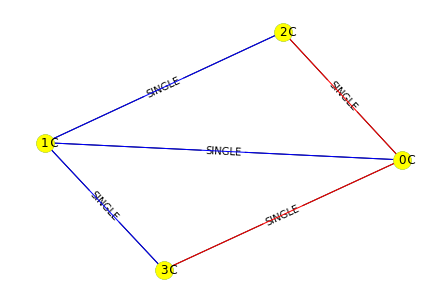

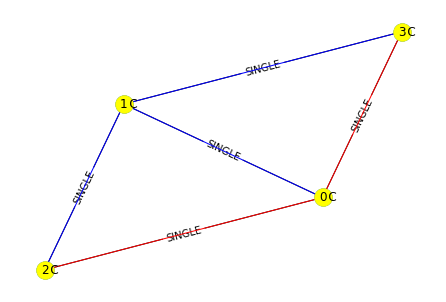

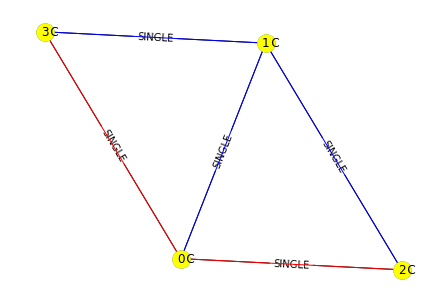

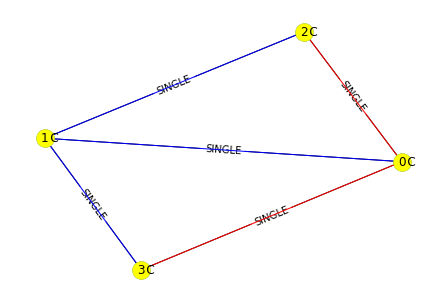

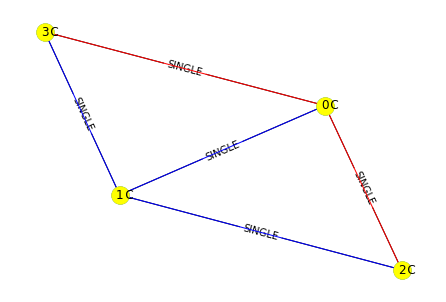

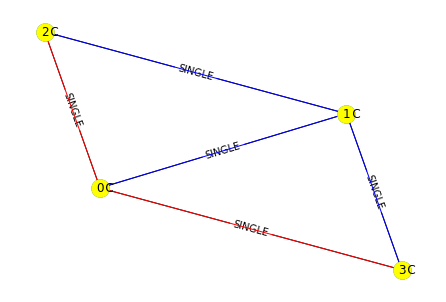

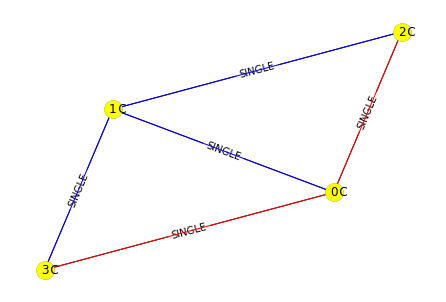

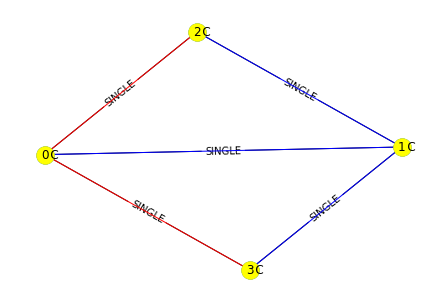

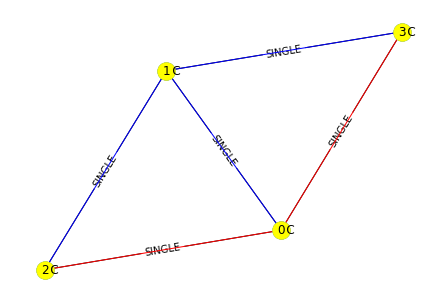

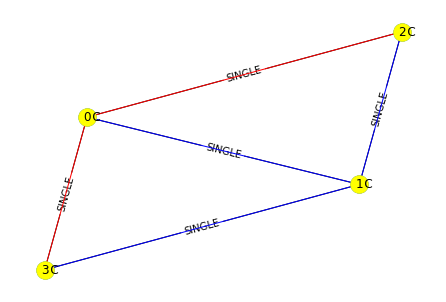

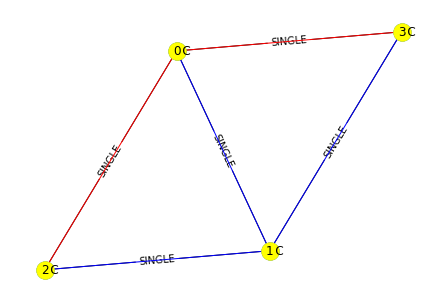

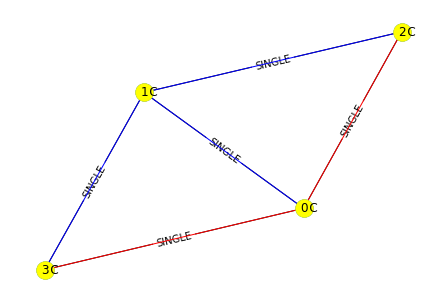

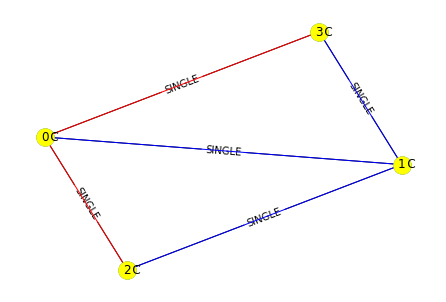

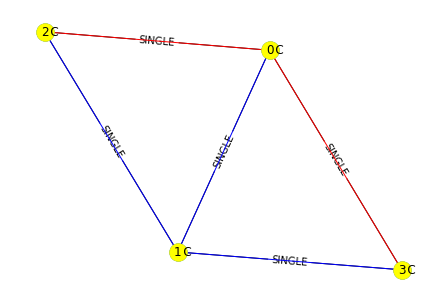

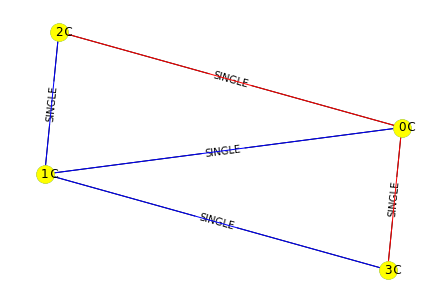

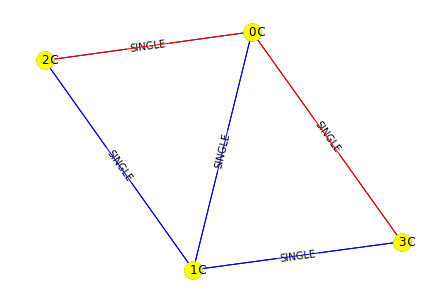

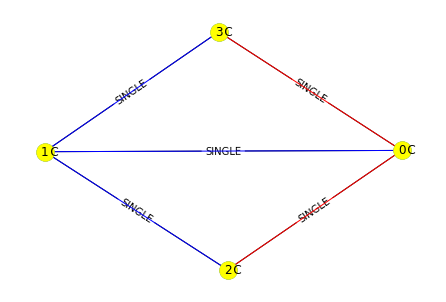

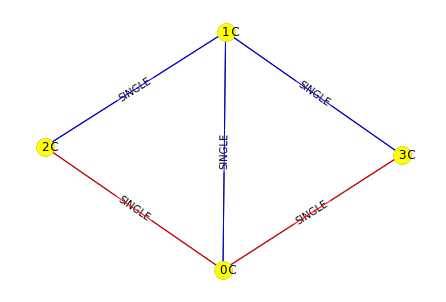

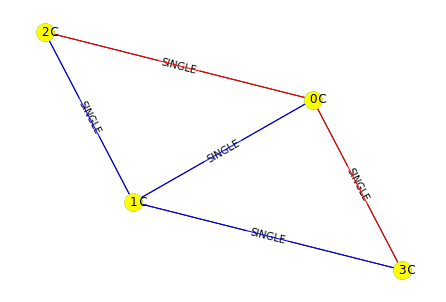

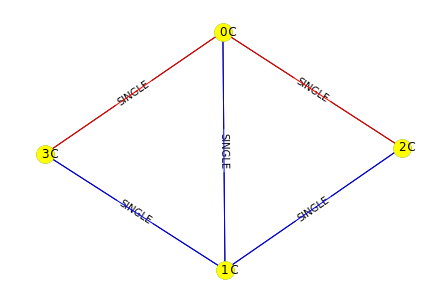

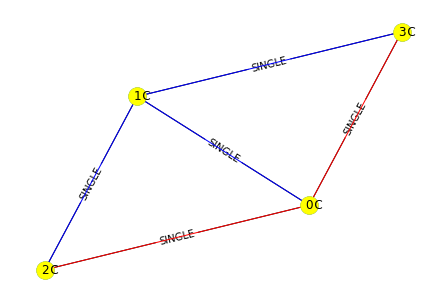

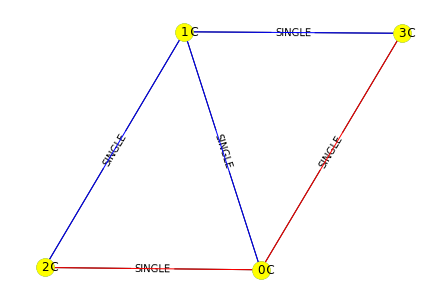

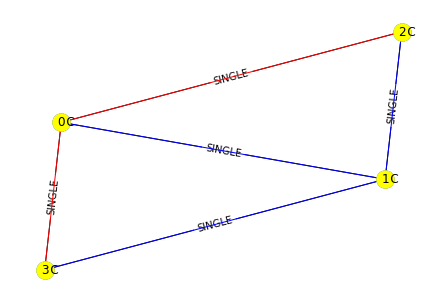

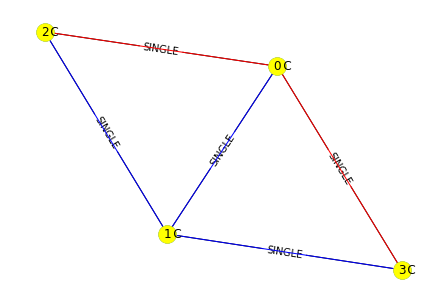

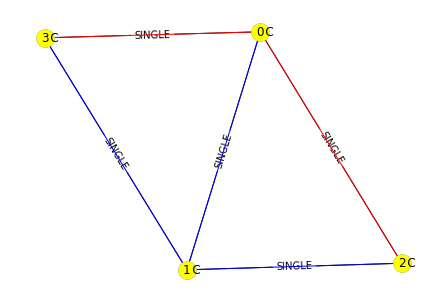

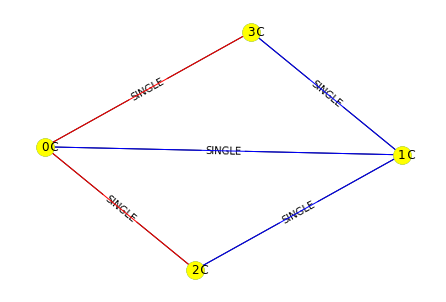

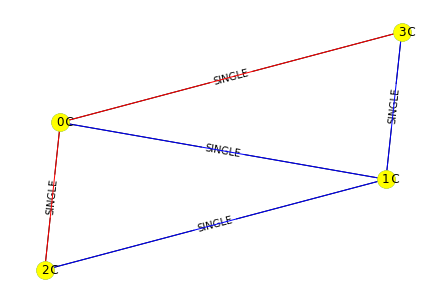

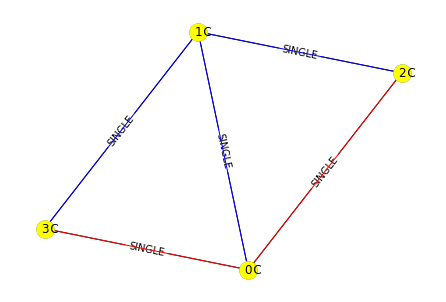

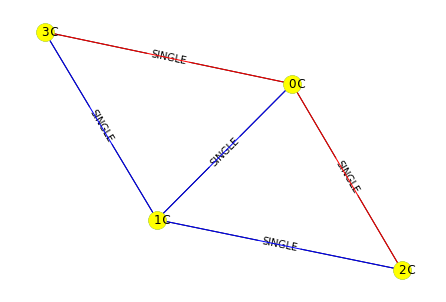

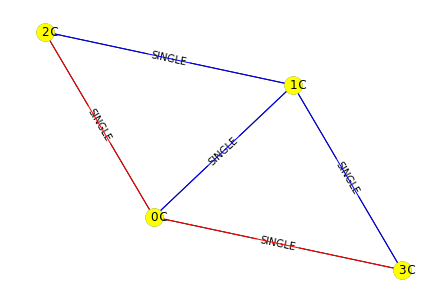

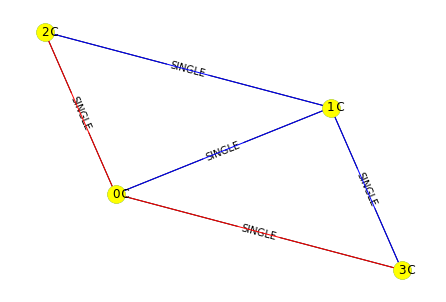

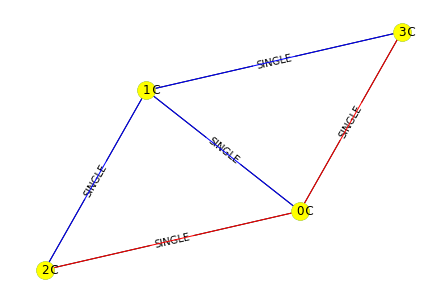

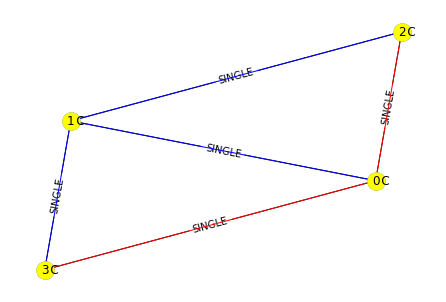

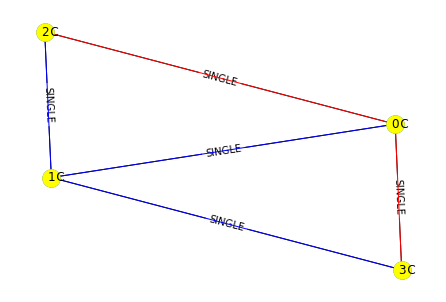

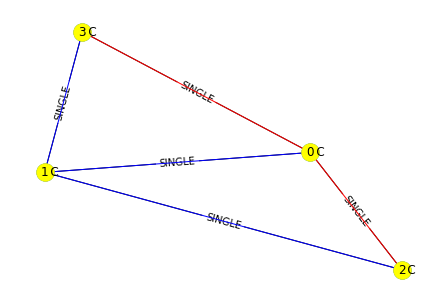

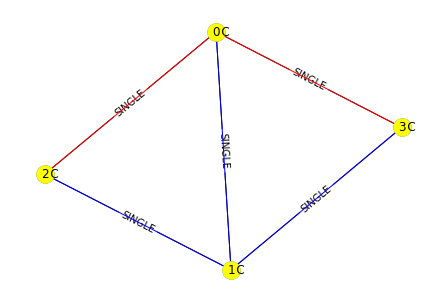

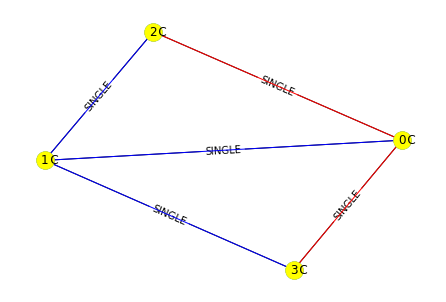

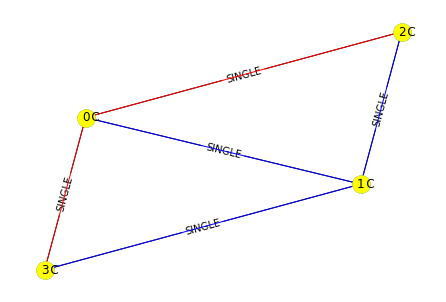

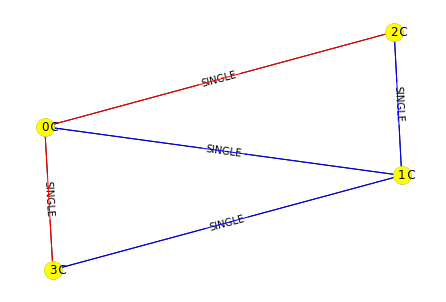

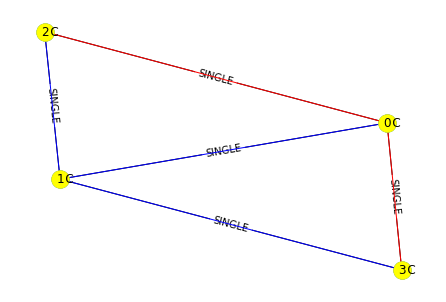

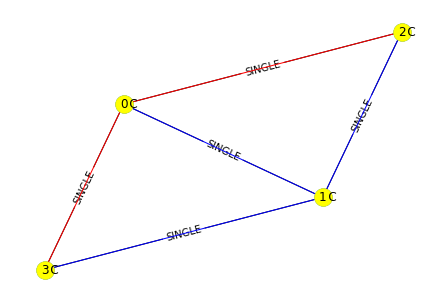

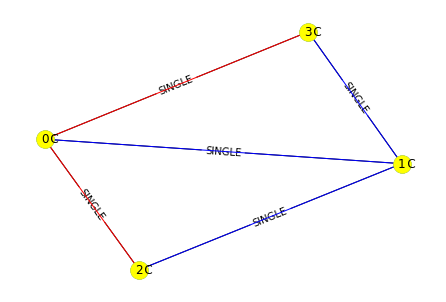

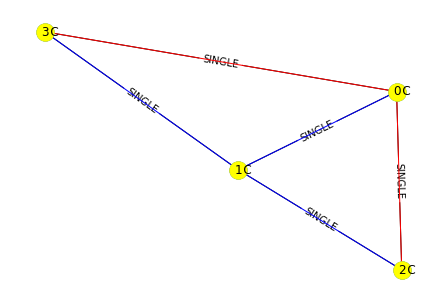

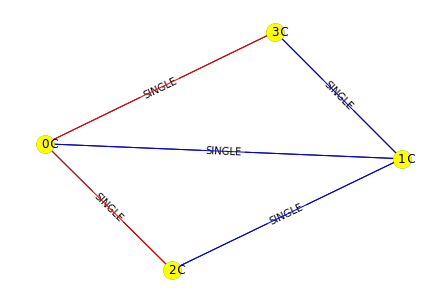

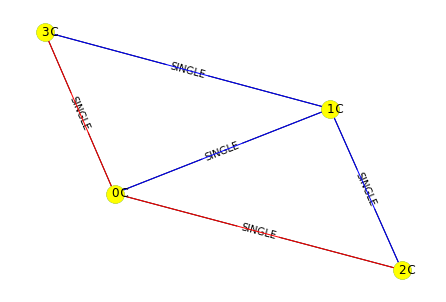

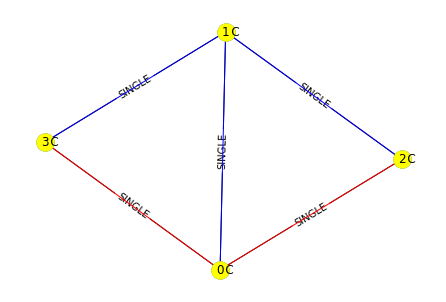

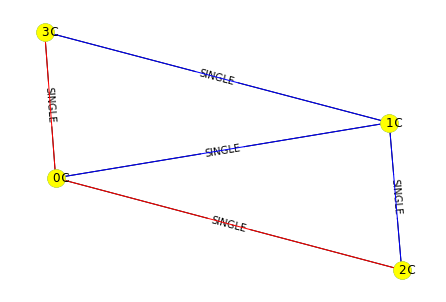

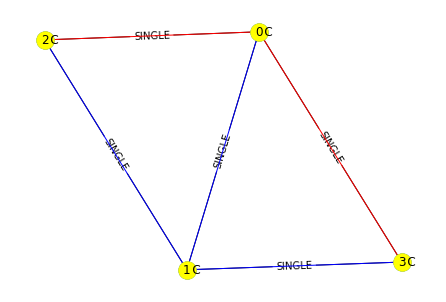

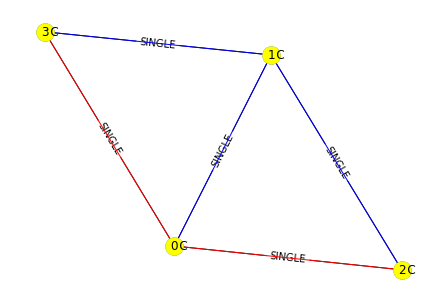

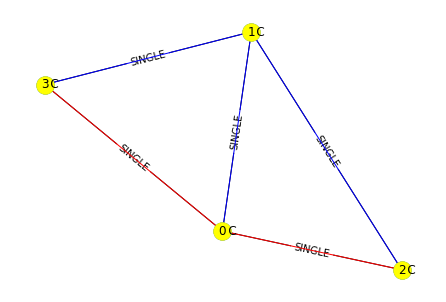

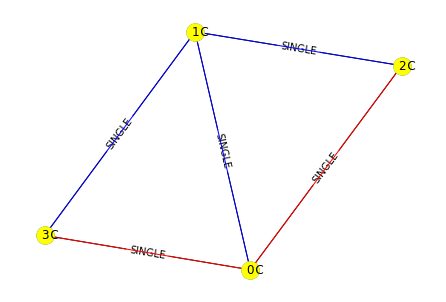

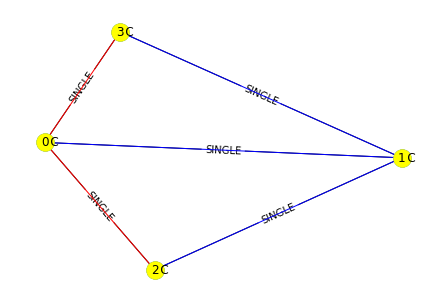

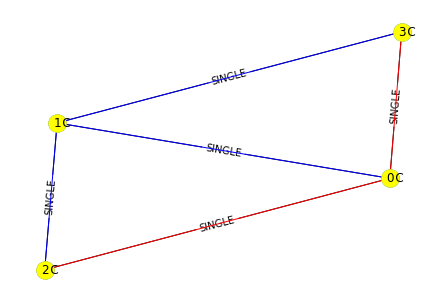

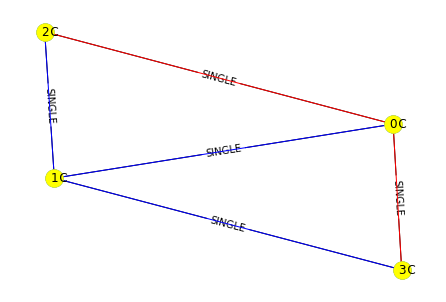

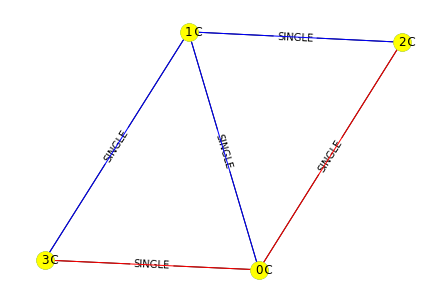

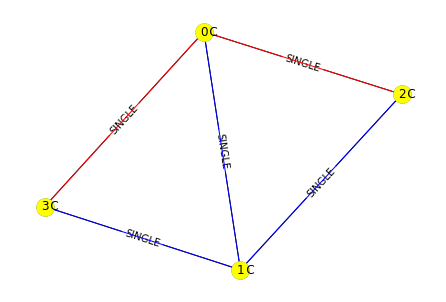

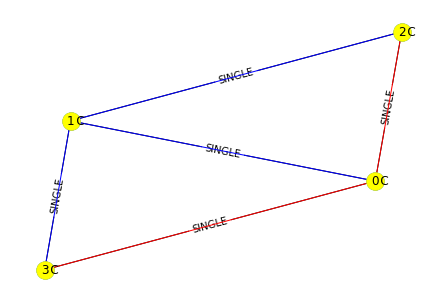

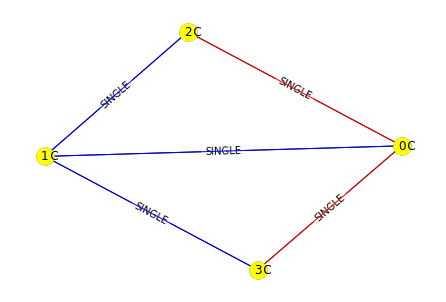

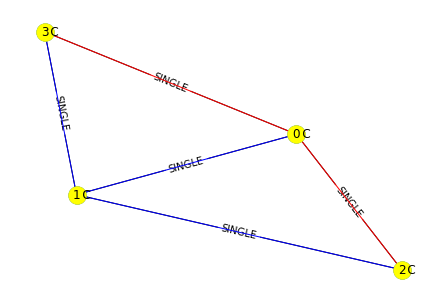

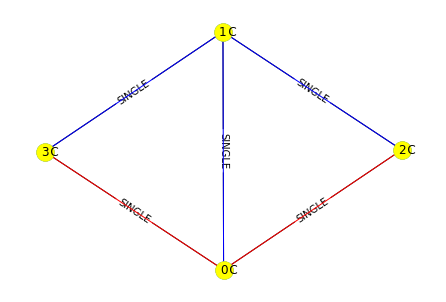

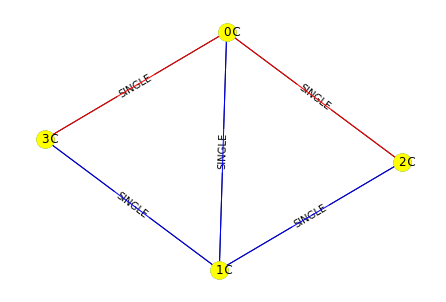

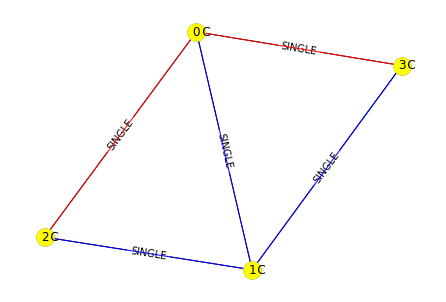

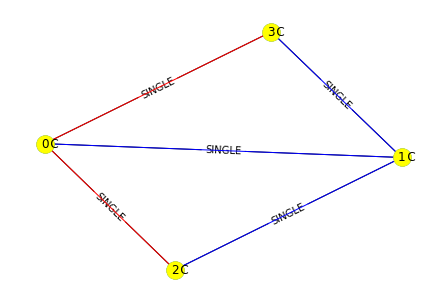

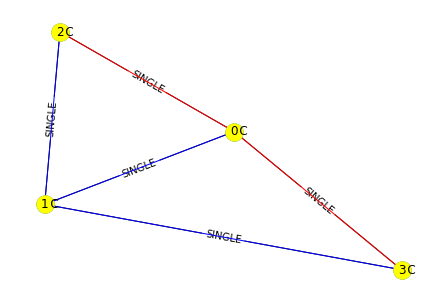

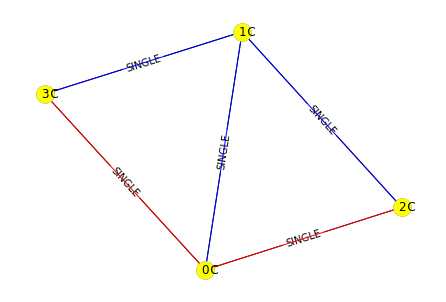

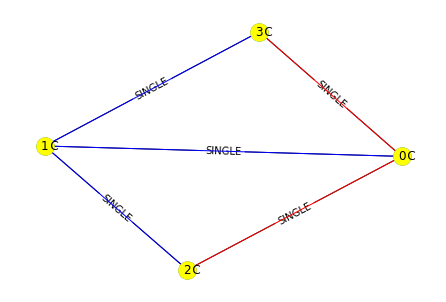

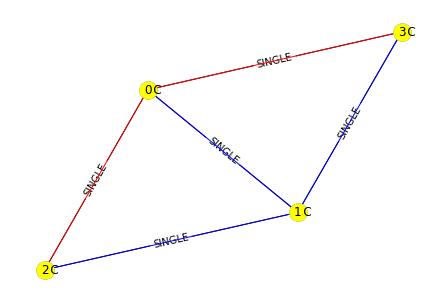

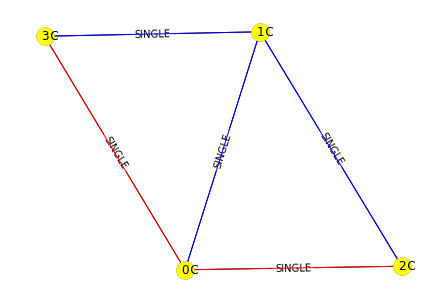

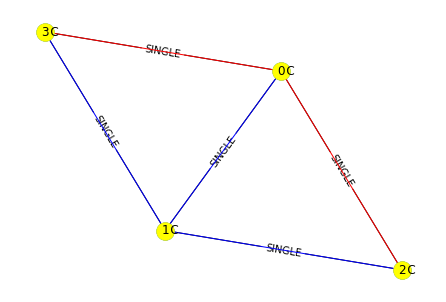

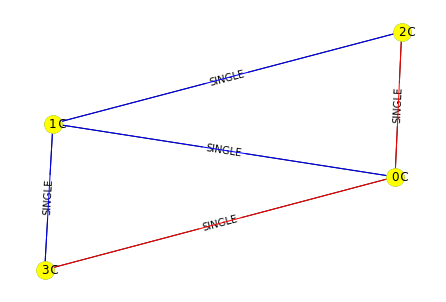

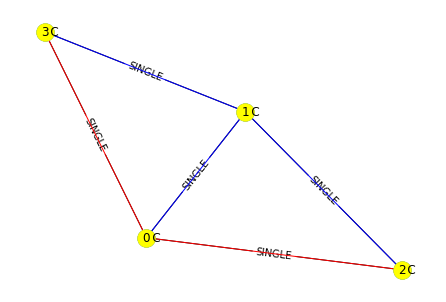

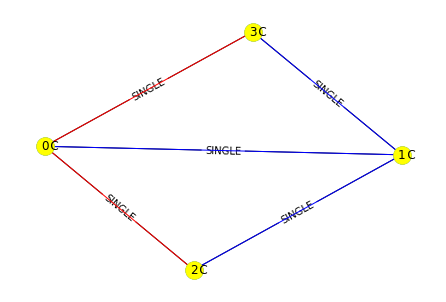

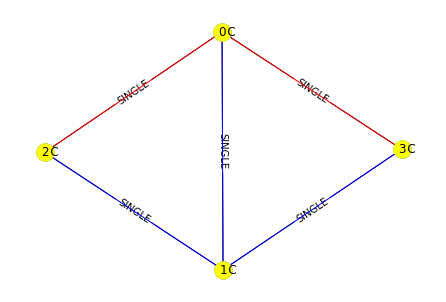

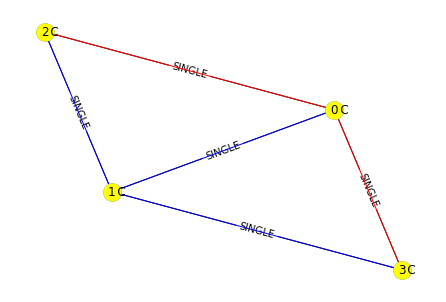

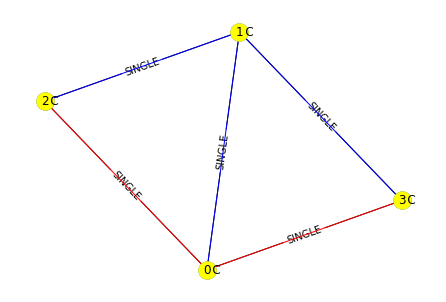

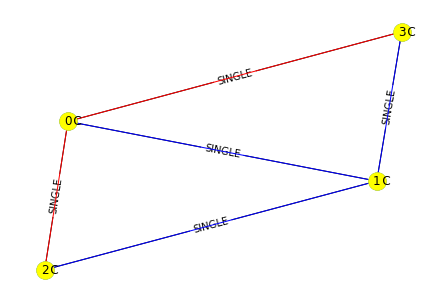

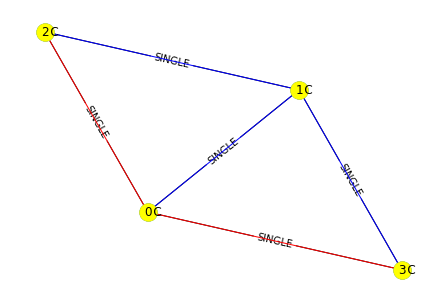

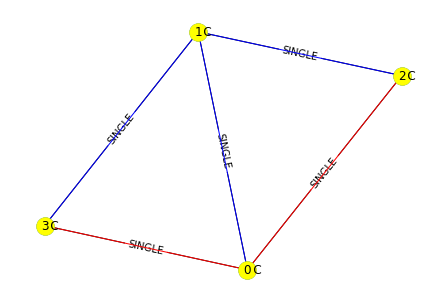

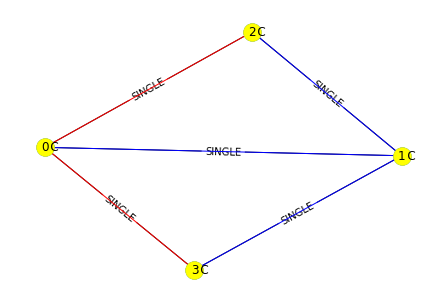

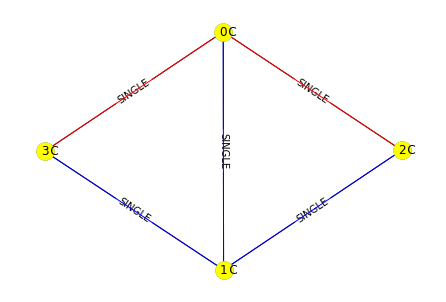

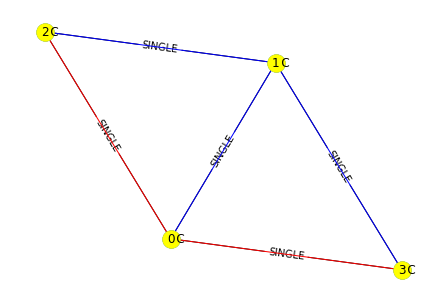

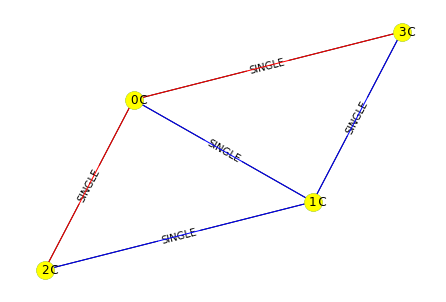

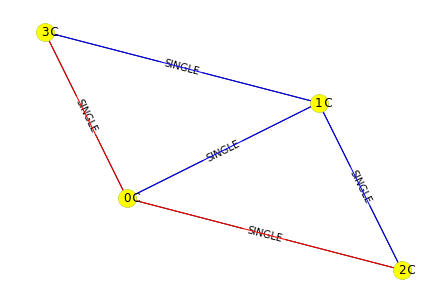

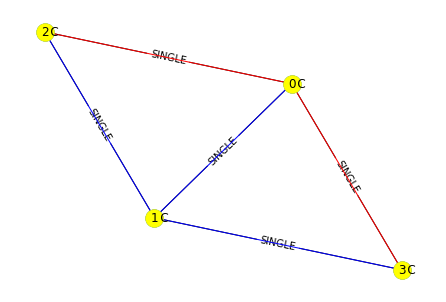

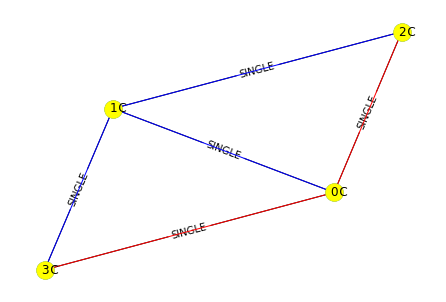

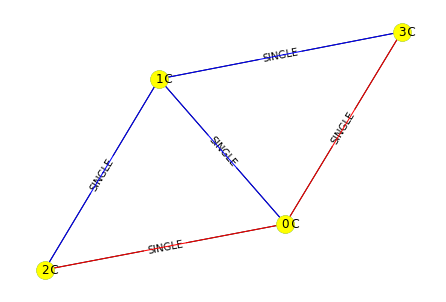

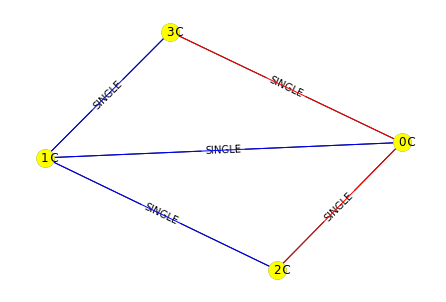

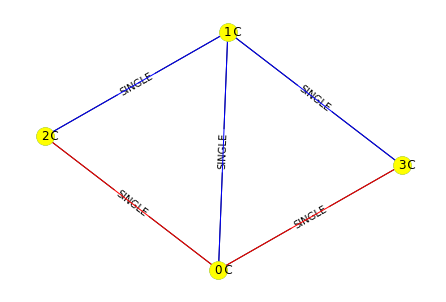

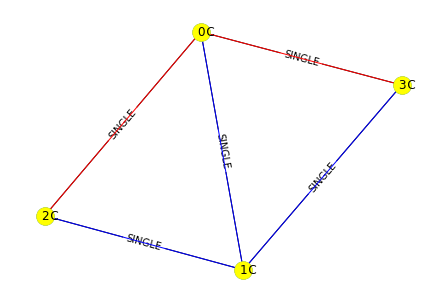

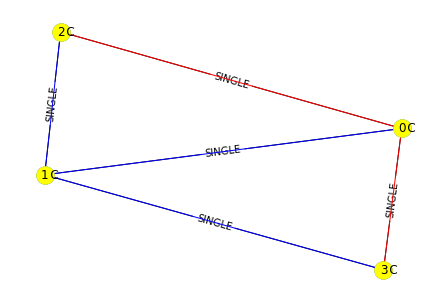

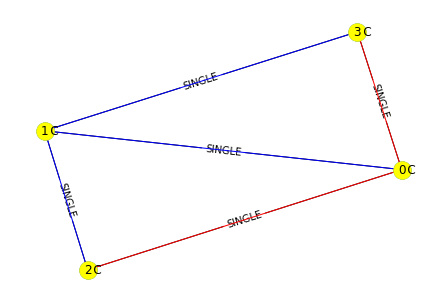

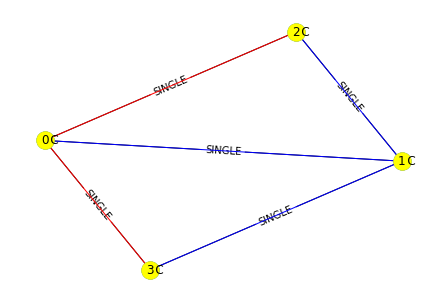

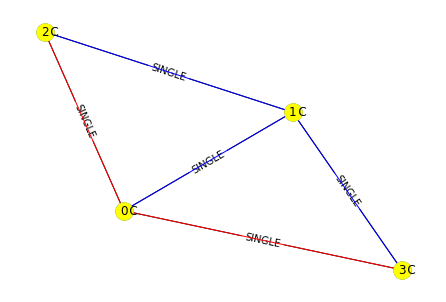

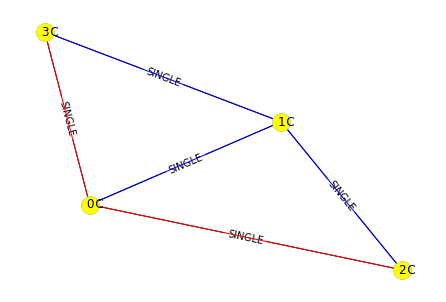

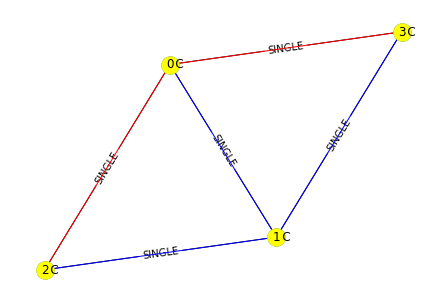

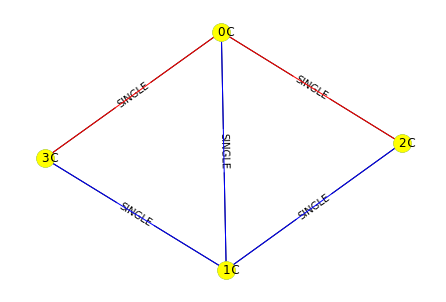

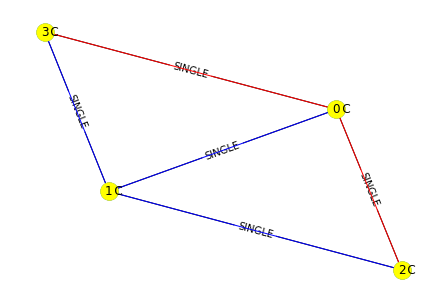

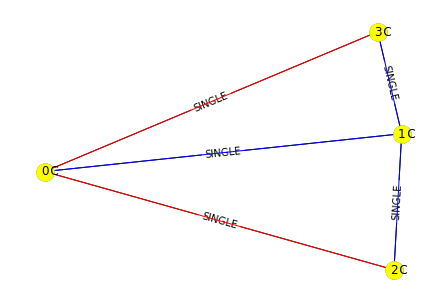

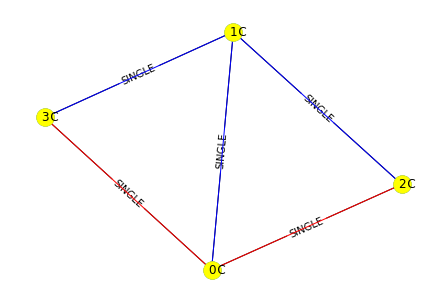

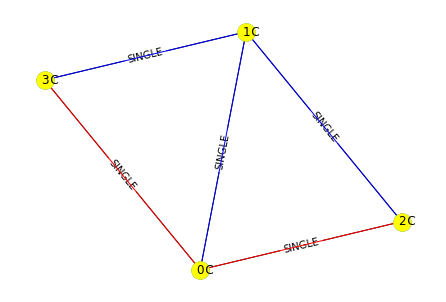

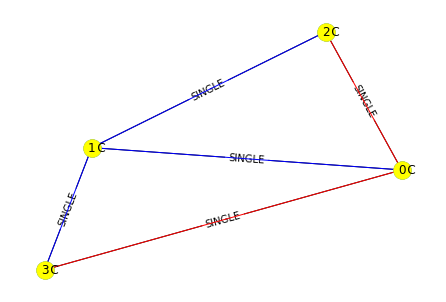

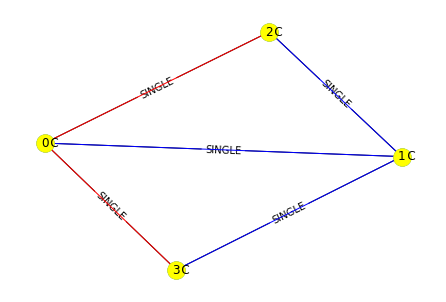

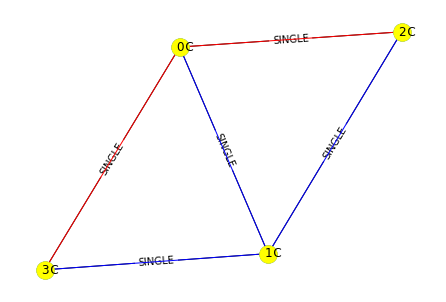

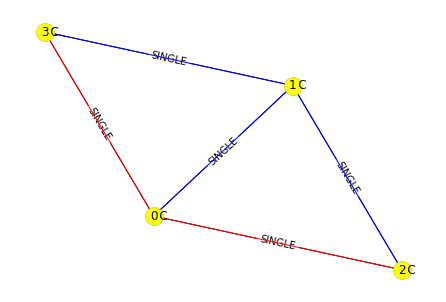

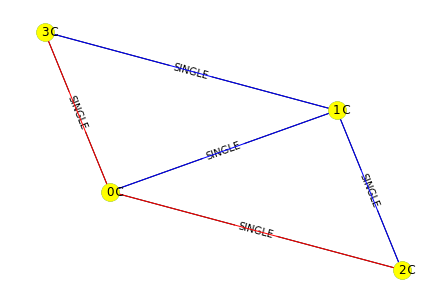

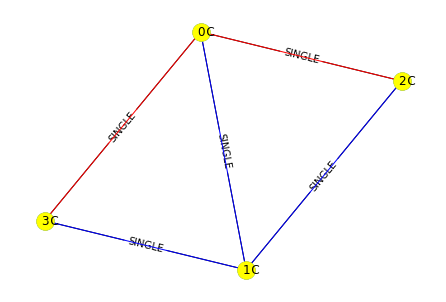

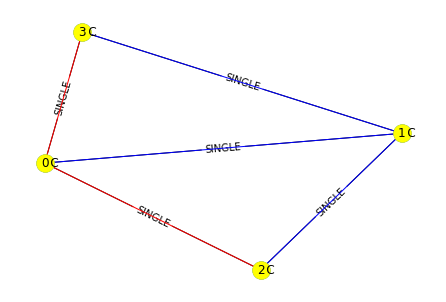

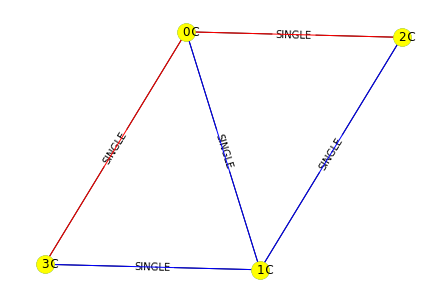

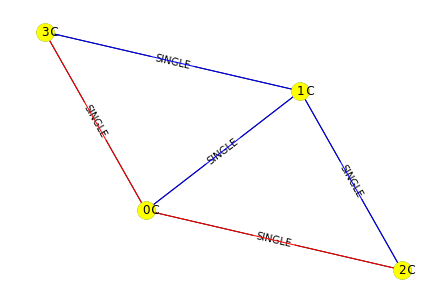

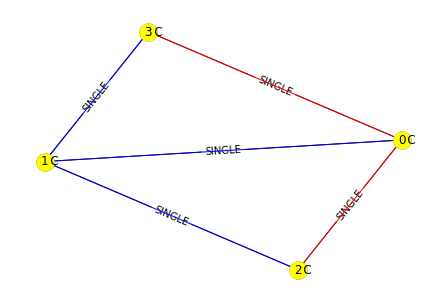

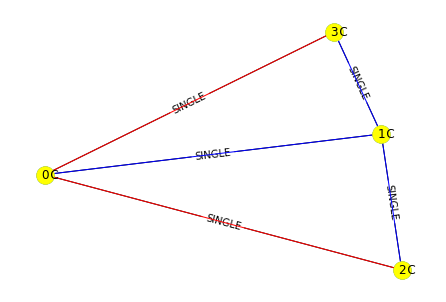

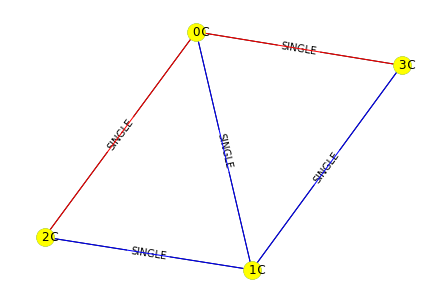

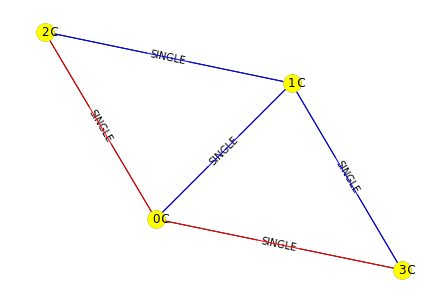

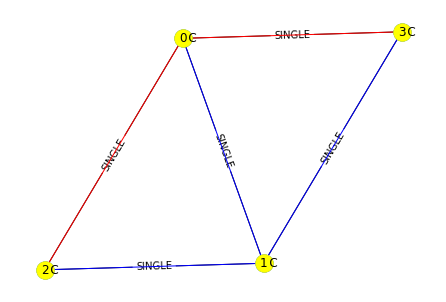

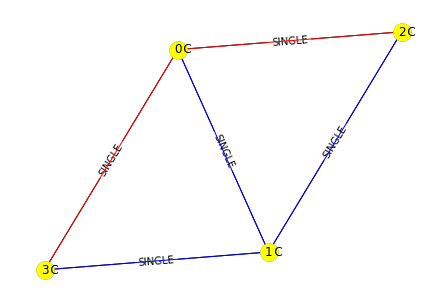

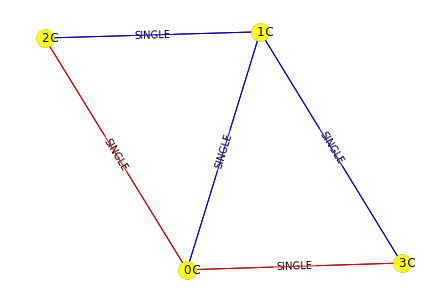

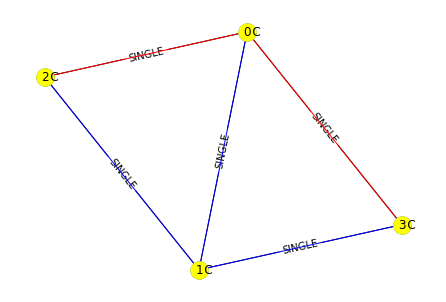

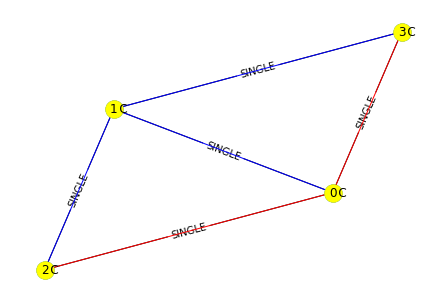

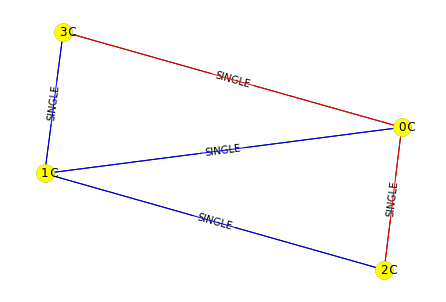

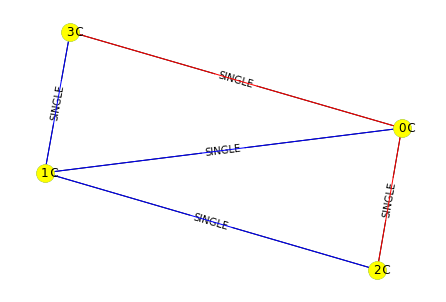

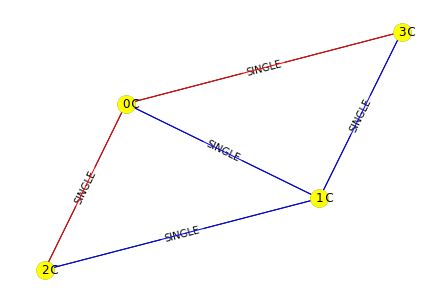

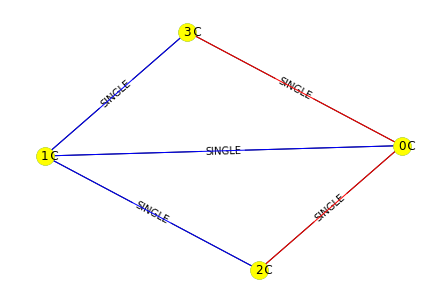

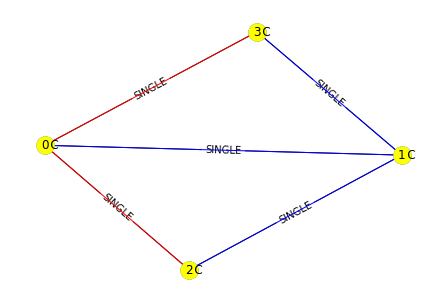

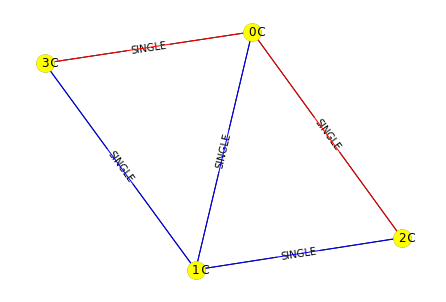

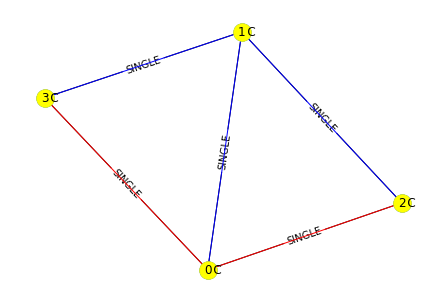

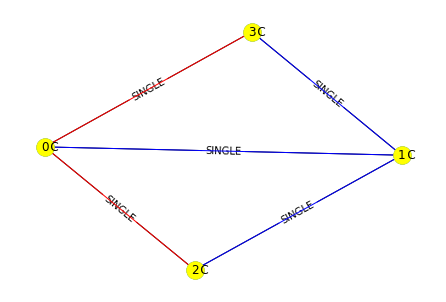

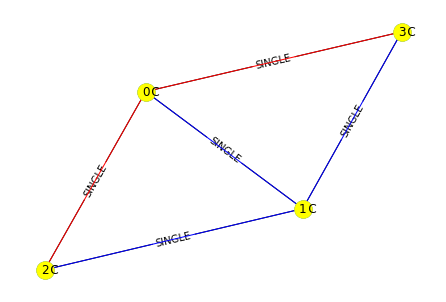

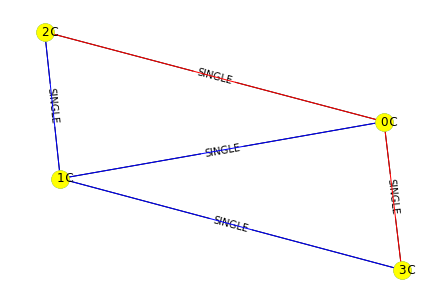

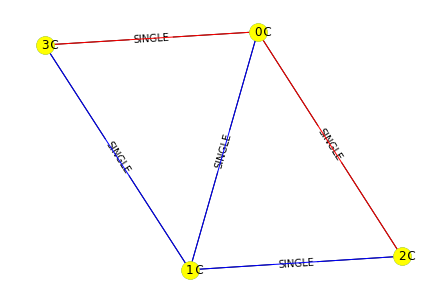

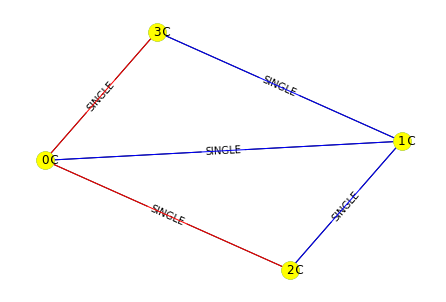

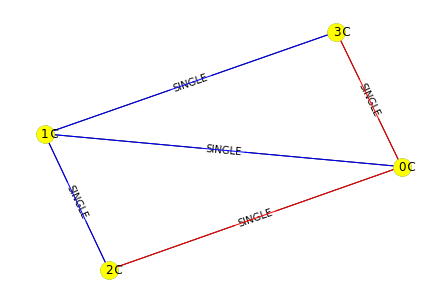

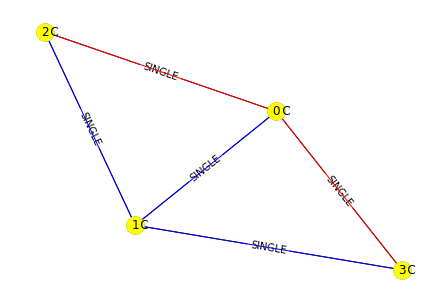

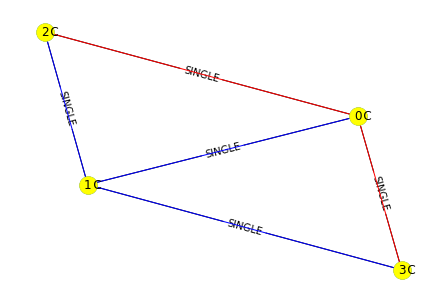

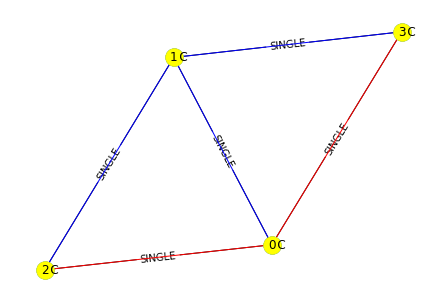

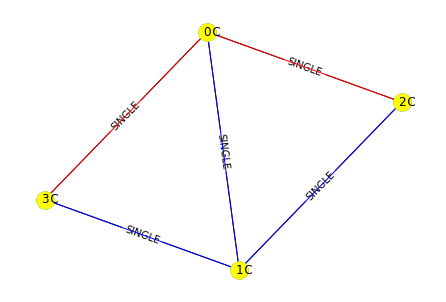

RuntimeError: No active exception to reraise

<Figure size 432x288 with 0 Axes>

In [24]:
def local_attach_graph(cand_G, nei_G, amap):
    for node in nei_G.nodes():
        if node not in amap:
            node_attr = copy_node_attr(nei_G, node)
            amap[node] = len(cand_G.nodes)
            cand_G.add_node(len(cand_G.nodes), **node_attr)
    
    for node1, node2, data in nei_G.edges(data=True):
        a1 = amap[node1]
        a2 = amap[node2]
        if not cand_G.has_edge(a1, a2):
            cand_G.add_edge(a1, a2, **data)

def enum_attach_single_bond(ctr_G, nei_G):
    cands_G = []
    for b1 in ctr_G.edges():
        b1_st, b1_ed = b1[0], b1[1]
        for b2 in nei_G.edges():
            b2_st, b2_ed = b2[0], b2[1]

            if ring_edge_equal(ctr_G, nei_G, b1, b2):
                cand_G = ctr_G.copy()
                amap = {b2_st : b1_st, b2_ed: b1_ed}
                local_attach_graph(cand_G, nei_G, amap)

                duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
                if not duplicate: cands_G.append(cand_G)
                # draw_mol(cand_G)
                # print('node1', cand_G.nodes())

            elif ring_edge_equal(ctr_G, nei_G, b1, b2, reverse=True):
                cand_G = ctr_G.copy()
                amap = {b2_st : b1_ed, b2_ed: b1_st}
                local_attach_graph(cand_G, nei_G, amap)
                
                duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
                if not duplicate: cands_G.append(cand_G)
                # print('node2', cand_G.nodes())

    return cands_G
                
def enum_attach_double_bond(ctr_G, nei_G):
    ctr_pair_bonds = []
    for node in ctr_G.nodes():
        nei_n_ctr = [(nei, node) for nei in ctr_G.neighbors(node)]
        subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
        ctr_pair_bonds.extend(subset_possible_bonds)

    nei_pair_bonds = []
    for node in nei_G.nodes():
        nei_n_ctr = [(nei, node) for nei in nei_G.neighbors(node)]
        subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
        nei_pair_bonds.extend(subset_possible_bonds)

    cands_G = []
    for b1, b2 in ctr_pair_bonds:
        ctr_ctr_node = list(set(b1).intersection(set(b2)))[0]
        ctr_left_node = list(set(b1) - set(b1).intersection(set(b2)))[0]
        ctr_right_node = list(set(b2) - set(b1).intersection(set(b2)))[0]
        
        for b3, b4 in nei_pair_bonds:
            nei_ctr_node = list(set(b3).intersection(set(b4)))[0]
            nei_left_node = list(set(b3) - set(b3).intersection(set(b4)))[0]
            nei_right_node = list(set(b4) - set(b3).intersection(set(b4)))[0]
    
            if ring_edge_equal(ctr_G, nei_G, b1, b3) and ring_edge_equal(ctr_G, nei_G, b2, b4):
                cand_G = ctr_G.copy()
                amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_left_node, nei_right_node: ctr_right_node}
                local_attach_graph(cand_G, nei_G, amap)

                # duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
                # if not duplicate: cands_G.append(cand_G)
                cands_G.append(cand_G)

            elif ring_edge_equal(ctr_G, nei_G, b1, b3, reverse=True) and ring_edge_equal(ctr_G, nei_G, b2, b4, reverse=True):
                cand_G = ctr_G.copy()
                amap = {nei_ctr_node : ctr_ctr_node, nei_left_node: ctr_right_node, nei_right_node: ctr_left_node}
                local_attach_graph(cand_G, nei_G, amap)

                duplicate = len([1 for G in cands_G if nx.is_isomorphic(G, cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)])
                if not duplicate: cands_G.append(cand_G)

    return cands_G
                
def enum_assemble_singleton_tri(node):

    neighbors = node.neighbors
    possible_cands_G = []
    cur_graph = neighbors[0].graph.copy()

    def search(cur_graph, depth):
        if depth == len(neighbors) - 1:
            possible_cands_G.append(cur_graph)
            return

        print('current depth', depth)

        nei_node = neighbors[depth]
        cands_G = enum_attach_single_bond(cur_graph, nei_node.graph)

        if depth >= 2: # double only start 
            cands_G.extend(enum_attach_double_bond(cur_graph, nei_node.graph))


        filtered_graph = []
        for i, cand_G in enumerate(cands_G): # subgraph pattern matching and filtering/ candidate tree pruning
            GM = iso.GraphMatcher(node.label_G ,cand_G, node_match=node_equal_iso, edge_match=ring_edge_equal_iso)
            if GM.subgraph_is_isomorphic(): filtered_graph.append(cand_G.copy())
        
        if len(filtered_graph) == 0:
            return
        
        for cand_G in filtered_graph:
            search(cand_G, depth + 1)

    search(cur_graph, 1)

    for i, cand in enumerate(possible_cands_G):
        draw_mol(cand, i)
    raise

    return possible_cands

def main():
    mol = Chem.MolFromSmiles("C1CC2CCC3CCCC4CCC(C1)C2C34")
    cliques = [
        (9, 15, 5), (9, 15, 14), (9, 12, 14),
        (12, 14, 2), (5, 15, 14), (15, 14, 2), (15,), (8, 9, 5)
    ]

    molTreeEdges = [
        (0, 6), (1, 6), (2, 6), (3, 6), (4, 6), (5, 6), (0, 7)
    ]

    list_of_nodes = []
    for clique in cliques:
        if isinstance(clique, tuple):
            c = list(clique)
            m = MolTreeNode(get_fragments(mol ,list(clique)), c)
        list_of_nodes.append(m)

    for x,y in molTreeEdges:
        list_of_nodes[x].add_neighbor(list_of_nodes[y])
        list_of_nodes[y].add_neighbor(list_of_nodes[x])

    for i,node in enumerate(list_of_nodes):
        node.nid = i + 1
        if len(node.neighbors) > 1: #Leaf node mol is not marked
            set_atommap(node.mol, node.nid)
            set_atommap(node.tri_mol, node.nid)
        node.is_leaf = (len(node.neighbors) == 1)

        # label only for singleton 
        tri_mol_count = [nei.tri_mol.GetNumAtoms() for nei in node.neighbors]
        if node.mol.GetNumAtoms() == 1 and len(node.neighbors) >= 3 and sum(tri_mol_count) >= 3 * len(tri_mol_count):
            cand_label = Chem.MolFromSmiles("C12C34C5C11C23C451")
            a1_count = 0
            a2_count = 0
            for bond in cand_label.GetBonds():
                a1 = bond.GetBeginAtom()
                a2 = bond.GetEndAtom()
                if len(a1.GetNeighbors()) == 3 and a1_count < 2:
                    bond.SetBoolProp(KEY, True)
                    a1_count += 1
                elif len(a2.GetNeighbors()) == 3 and a2_count < 2:
                    bond.SetBoolProp(KEY, True)
                    a2_count += 1
                else:
                    bond.SetBoolProp(KEY, False)

            cand_G_label = mol_to_nx(cand_label)
            cand_label = Chem.MolToSmiles(cand_label)
            node.label = cand_label
            node.label_G = cand_G_label

    root = list_of_nodes[-2]
    enum_assemble_singleton_tri(root)

main()

In [ ]:
nei_mol = Chem.MolFromSmiles("C1C=C1")
nei_pair_bonds = []
for atom in nei_mol.GetAtoms():
    nei_n_ctr = [(atom.GetIdx(), nei.GetIdx()) for nei in atom.GetNeighbors()]
    subset_possible_bonds = list(itertools.combinations(nei_n_ctr, 2))
    nei_pair_bonds.extend(subset_possible_bonds)
print(nei_pair_bonds)

def show_atom_number(mol, label):
    for atom in mol.GetAtoms():
        atom.SetProp(label, str(atom.GetIdx()))
    return mol
show_atom_number(Chem.RWMol(nei_mol), "molAtomMapNumber")

In [ ]:
# G = nx.Graph()

# for i, node in enumerate(molTreeNodes):
#     G.add_node(node, nid=i)

# for edge in molTreeEdges:
#     G.add_edge(*edge)

# f, ax = plt.subplots(figsize=(15, 6)) 
# nx.draw(G, node_color="yellow", with_labels=True,)
# plt.show()